 # Análise de Inadimplência - X-Health

 ## Índice da Análise



 1. Business Problem

     * Starting Context

         * Business Understanding

 2. Setup Phase

     * CRISP-DM

 3. Analysis Phase

     * Data Collection

     * Data Cleaning

         * Feature Extraction

     * Data Analysis

         * Descriptive Data Analysis

         * Hypotheses Mindmap

         * Exploratory Data Analysis

 # Business Problem

 ## Contexto Inicial

 O time financeiro da X-Health, uma empresa B2B de dispositivos eletrônicos de saúde, observou um aumento nos casos de não-pagamento (default) em vendas a crédito. Eles desejam uma solução para prever quais clientes podem dar calote, minimizando esse impacto financeiro.

 ##### Entendimento do Negócio

 Perguntas fundamentais para entender o problema:

 * Qual a Motivação?

     - Reduzir perdas financeiras devido a calotes em vendas a crédito.

 * Qual a causa raiz do problema?

     - Falta de um modelo preditivo para identificar clientes de risco antes da venda de produtos a crédito.

 * Quem é o dono do problema?

     - Time financeiro da X-Health.

 * Qual o formato da solução de deploy?

     - Granularidade:

         - Previsão por evento de compra (cada linha do dataset), por cliente.

     - Tipo de Análise:

         - Classificação binária (default = 0 ou 1).

     - Potenciais Métodos:

         - Modelos como Logistic Regression, Random Forest, ou XGBoost.

     - Formato de deploy:

         - Função preditiva em Jupyter Notebook que retorna {"default": 0} ou {"default": 1}.

         - Sugestões posteriores sobre o formato de deploy (API, web service, etc.).

 # Setup Phase

 ## Libraries

In [1]:
try:
    # Fundamental Analytics libraries
    import pandas as pd
    import seaborn as sns
    import numpy as np
    from matplotlib import pyplot as plt
    from scipy import stats as sts
    # Toolbox libraries
    import time
    import math
    import pickle
    import random
    import requests
    import inflection
    import warnings
    from operator import itemgetter as pick
    from datetime import datetime, timedelta
    from tabulate import tabulate
    from IPython.display import Image
    from IPython.core.display import HTML
    # Custom toolbox libraries
    from Modules.Tables import get_column_names, get_dimensions, get_dataset_types, get_missing_values, get_broadview_miss_val, get_num_statistics_metrics, get_unique_cat_values, get_analysis_conclusions
    from Modules.Training import classification_metrics, crossval_xgboost, save_model
    from Modules.Predict import open_model
    # Metrics libraries
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
    from sklearn.metrics import roc_curve, auc, precision_recall_curve
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    
    # Encoder and Scaler libraries
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
    
    # Train-Test libraries
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    
    # Feature and Parameter Selection libraries
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    from boruta import BorutaPy
    
    # Model libraries
    from sklearn.dummy import DummyClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import GaussianNB
    from xgboost import XGBClassifier
    import xgboost as xgblib
    
    # Initial configurations
    warnings.filterwarnings('ignore')
    warnings.simplefilter(action = 'ignore', category = FutureWarning)
    xgblib.set_config(verbosity = 0)
    print("Import successful")
    
except Exception as e:
    
    print("Error while importing libraries: ", "\n", e)



Error while importing libraries:  
 cannot import name 'open_model' from 'Modules.Training' (c:\Users\Andrew\Desenvolvimento\Default_Analysis_Challenge\Modules\Training.py)


 ## Notebook Settings

In [2]:
def notebook_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [30, 15]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.float_format = '{:}'.format
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    #pd.set_option('display.expand_frame_repr', False)
    sns.set()
    
notebook_settings()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


 ## CRISP-DM

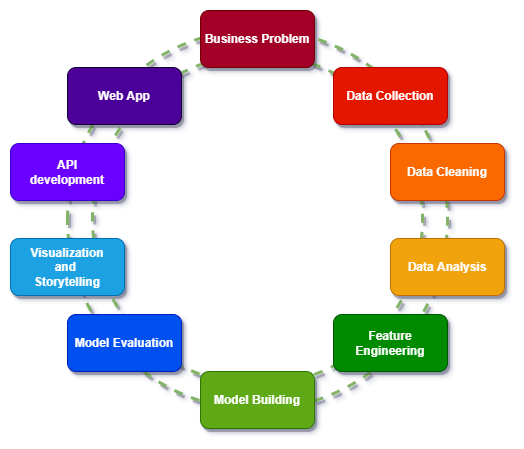

In [3]:
Image(filename='./Assets/Images/Data Science Project Cycle.png', width=600, height=550)

 ##### Procedimento padrão dos projetos de Data Science

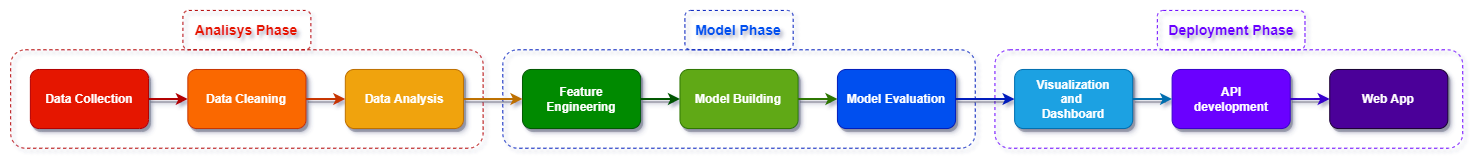

In [4]:
Image(filename='./Assets/Images/Data Science Project Guide.png')

 ## Dataset

 #### Files

 * dataset_2021-5-26-10-14.csv - Dados históricos de vendas a crédito da X-Health.

 #### Data fields

 - Estrutura do .csv: para ler o arquivo, use  sep = '\t' e encoding = 'utf-8'.

 - O dataset possui tanto variáveis internas (decorrentes do comportamento histórico do cliente B2B junto à X-Health), quanto variáveis externas consultadas em bureaus de crédito, como o Serasa.

 - Cada linha do dataset representa um evento de compra de um conjunto de produtos, e tanto as variáveis internas quanto externas representam uma fotografia do cliente naquele instante.

 - Valores faltantes estão indicados no dataset como "missing".

 - Dicionário de dados:



 | nome_coluna                    | desc                                                                                               |
 | --------------------------     |----------------------------------------------------------------------------------------- |
 | default\_3months               |Quantidade de default nos últimos 3 meses                                                          |
 | ioi\_Xmonths                   |Intervalo médio entre pedidos (em dias) nos últimos X meses                                       |
 | valor\_por\_vencer             |Total em pagamentos a vencer do cliente B2B, em Reais     |
 | valor\_vencido                 |Total em pagamentos vencidos do cliente B2B, em Reais                                              |
 | valor\_quitado                 |Total (em Reais) pago no histórico de compras do cliente B2B                |
 | quant\_protestos               |Quantidade de protestos de títulos de pagamento apresentados no Serasa|
 | valor\_protestos               |Valor total (em Reais) dos protestos de títulos de pagamento apresentados no Serasa|
 | quant\_acao_judicial           |Quantidade de ações judiciais apresentadas pelo Serasa|
 | acao\_judicial\_valor          |Valor total das ações judiciais (Serasa) |
 | participacao\_falencia\_valor  |Valor total (em Reais) de falências apresentadas pelo Serasa |
 | dividas\_vencidas\_valor       |Valor total de dívidas vencidas (Serasa)|
 | dividas\_vencidas\_qtd         |Quantidade total de dívidas vencidas (Serasa)|
 | falencia\_concordata\_qtd      |Quantidade de concordatas (Serasa)|
 | tipo\_sociedade                |Tipo de sociedade do cliente B2B |
 | opcao\_tributaria              |Opção tributária do cliente B2B |
 | atividade\_principal           |Atividade principal do cliente B2B|
 | forma\_pagamento               |Forma de pagamento combinada para o pedido |
 | valor\_total\_pedido           |Valor total (em Reais) do pedido em questão|
 | month                          |Mês do pedido|
 | year                           |Ano do pedido|
 | default                        |Status do pedido: default = 0 (pago em dia), default = 1 (pagamento não-realizado, calote concretizado)|

 No caso desta análise, a parte da coleta de dados ja foi feita e está disponível em um arquivo CSV, portanto vamos começar pela limpeza e descrição dos dados.

 # Analysis Phase



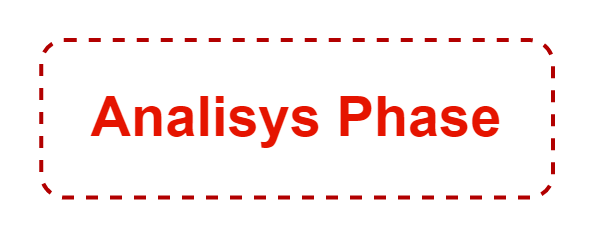

In [5]:
Image(filename='./Assets/Images/Analysis Phase.png', width=250, height=100)

 ## Data Collection

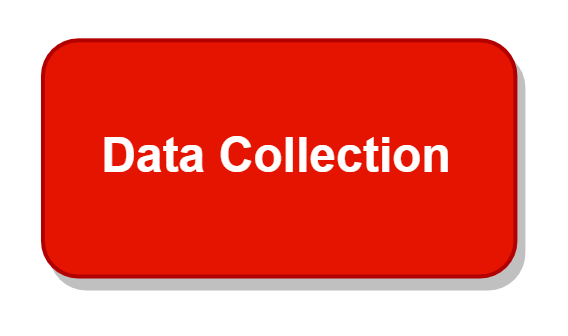

In [6]:
Image(filename='./Assets/Images/Data Collection.png', width=200, height=100)

 Como neste projeto não vamos usar comunicação com API ou SQL, vamos carregar os dados a partir de um arquivo .CSV

 ### Loading Data

In [7]:
try:
    df_raw = pd.read_csv('./Data/Raw/dataset_2021-5-26-10-14.csv', sep = '\t', encoding = 'utf-8')
    print("Loading successful")
except Exception as e:
    print("Error while loading data: ", "\n", e)

Loading successful


 ## Data Cleaning

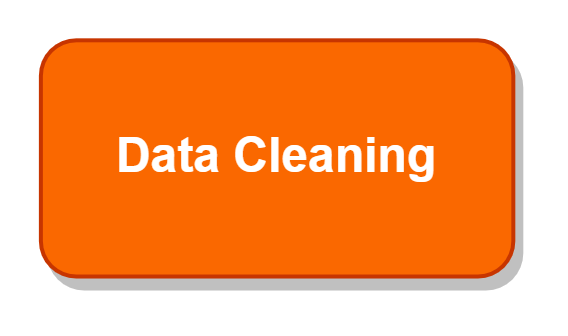

In [8]:
Image(filename='./Assets/Images/Data Cleaning.png', width=200, height=100)

In [9]:
df_raw.head()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,dividas_vencidas_qtd,falencia_concordata_qtd,tipo_sociedade,opcao_tributaria,atividade_principal,forma_pagamento,valor_total_pedido,month,year,default
0,0,58.0,18.236092447000644,0.0,0.0,242100.7,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,papelaria,30/60/90,34665.6749381255,6,2019,0
1,1,16.05263157894737,7.5,224132.85,0.0,4960846.21,0,0.0,0,0.0,...,0,0,sociedade empresaria limitada,missing,com de equipamentos de informatica,30/60/90,7134.489373085977,10,2018,0
2,0,13.25,3.9047619047619047,513043.83,0.0,158631.93,1,1800.0,0,0.0,...,0,0,sociedade empresaria limitada,simples nacional,servicos de vigilancia e guarda,missing,72653.621142701,4,2018,0
3,0,136.925,10.144219114219114,23273.64,0.0,669644.16,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,com de equipamentos de informatica,missing,14576.805782852463,4,2017,1
4,0,140.33333333333334,17.651677911672586,0.0,0.0,2010.56,0,0.0,0,0.0,...,0,0,sociedade empresaria limitada,simples nacional,com de compon eletron e pecas para eletrod,30/60/90,2655.5056625559423,10,2017,0


 ### Rename Columns

Vamos renomear as colunas para snake case

In [10]:
col_df, colunas = get_column_names(df_raw)
col_df

|| Retrieve column names from DataFrame


,Columns
0,default_3months
1,ioi_36months
2,ioi_3months
3,valor_por_vencer
4,valor_vencido
5,valor_quitado
6,quant_protestos
7,valor_protestos
8,quant_acao_judicial
9,acao_judicial_valor


In [11]:
snakecase = lambda column: inflection.underscore(column)
Colunas_new = list(map(snakecase, colunas))
df_raw.columns = Colunas_new
col_df, colunas = get_column_names(df_raw)
col_df

|| Retrieve column names from DataFrame


,Columns
0,default_3months
1,ioi_36months
2,ioi_3months
3,valor_por_vencer
4,valor_vencido
5,valor_quitado
6,quant_protestos
7,valor_protestos
8,quant_acao_judicial
9,acao_judicial_valor


 ### Data Dimensions

Vendo as dimensões do dataset

In [12]:
get_dimensions(df_raw)

|| Get dimensions (rows and columns) of DataFrame


,Dimensions
Columns,22
Rows,117273


 ### Data Types

Vendo os formatos de cada coluna

In [13]:
get_dataset_types(df_raw)

|| Identify data types of DataFrame columns


,Data_Type
Column,
default_3months,int64
ioi_36months,float64
ioi_3months,float64
valor_por_vencer,float64
valor_vencido,float64
valor_quitado,float64
quant_protestos,int64
valor_protestos,float64
quant_acao_judicial,int64


In [14]:
# Conversão de tipos
df_raw['month'] = df_raw['month'].astype(int)
df_raw['year'] = df_raw['year'].astype(int)
df_raw['default'] = df_raw['default'].astype(int)

get_dataset_types(df_raw)

|| Identify data types of DataFrame columns


,Data_Type
Column,
default_3months,int64
ioi_36months,float64
ioi_3months,float64
valor_por_vencer,float64
valor_vencido,float64
valor_quitado,float64
quant_protestos,int64
valor_protestos,float64
quant_acao_judicial,int64


 ### Missing Values

Vamos substituir "missing" por NaN

In [15]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117273 entries, 0 to 117272
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   default_3months              117273 non-null  int64  
 1   ioi_36months                 117273 non-null  float64
 2   ioi_3months                  117273 non-null  float64
 3   valor_por_vencer             117273 non-null  float64
 4   valor_vencido                117273 non-null  float64
 5   valor_quitado                117273 non-null  float64
 6   quant_protestos              117273 non-null  int64  
 7   valor_protestos              117273 non-null  float64
 8   quant_acao_judicial          117273 non-null  int64  
 9   acao_judicial_valor          117273 non-null  float64
 10  participacao_falencia_valor  117273 non-null  float64
 11  dividas_vencidas_valor       117273 non-null  float64
 12  dividas_vencidas_qtd         117273 non-null  int64  
 13 

In [16]:
df_raw.isnull().sum()

default_3months                0
ioi_36months                   0
ioi_3months                    0
valor_por_vencer               0
valor_vencido                  0
valor_quitado                  0
quant_protestos                0
valor_protestos                0
quant_acao_judicial            0
acao_judicial_valor            0
participacao_falencia_valor    0
dividas_vencidas_valor         0
dividas_vencidas_qtd           0
falencia_concordata_qtd        0
tipo_sociedade                 0
opcao_tributaria               0
atividade_principal            0
forma_pagamento                0
valor_total_pedido             0
month                          0
year                           0
default                        0
dtype: int64

In [17]:
(df_raw == 'missing').sum()

default_3months                    0
ioi_36months                       0
ioi_3months                        0
valor_por_vencer                   0
valor_vencido                      0
valor_quitado                      0
quant_protestos                    0
valor_protestos                    0
quant_acao_judicial                0
acao_judicial_valor                0
participacao_falencia_valor        0
dividas_vencidas_valor             0
dividas_vencidas_qtd               0
falencia_concordata_qtd            0
tipo_sociedade                   608
opcao_tributaria               18325
atividade_principal              592
forma_pagamento                32477
valor_total_pedido                 0
month                              0
year                               0
default                            0
dtype: int64

In [18]:
df_raw = df_raw.replace("missing", np.nan)
get_missing_values(df_raw)

|| Count missing values per column


,Missing_Values
Column,
forma_pagamento,32477
opcao_tributaria,18325
tipo_sociedade,608
atividade_principal,592
default_3months,0
ioi_36months,0
valor_quitado,0
valor_vencido,0
valor_por_vencer,0


In [19]:
df_raw.sample(1)[['forma_pagamento']]


,forma_pagamento
26781,30/45/60


In [20]:
# visão ampla de valores faltantes
missing_values, missing_columns_names = get_broadview_miss_val(df_raw)
missing_values

|| Broadview of missing values with percentages


,Absolute Missing (%),Column Missing (%),Column Remaining (%),Column Total,Column Missing
Column,,,,,
forma_pagamento,27.69%,27.69%,72.31%,84796,32477
opcao_tributaria,15.63%,15.63%,84.37%,98948,18325
tipo_sociedade,0.52%,0.52%,99.48%,116665,608
atividade_principal,0.50%,0.50%,99.50%,116681,592
default_3months,0.00%,0.00%,100.00%,117273,0
ioi_36months,0.00%,0.00%,100.00%,117273,0
valor_quitado,0.00%,0.00%,100.00%,117273,0
valor_vencido,0.00%,0.00%,100.00%,117273,0
valor_por_vencer,0.00%,0.00%,100.00%,117273,0


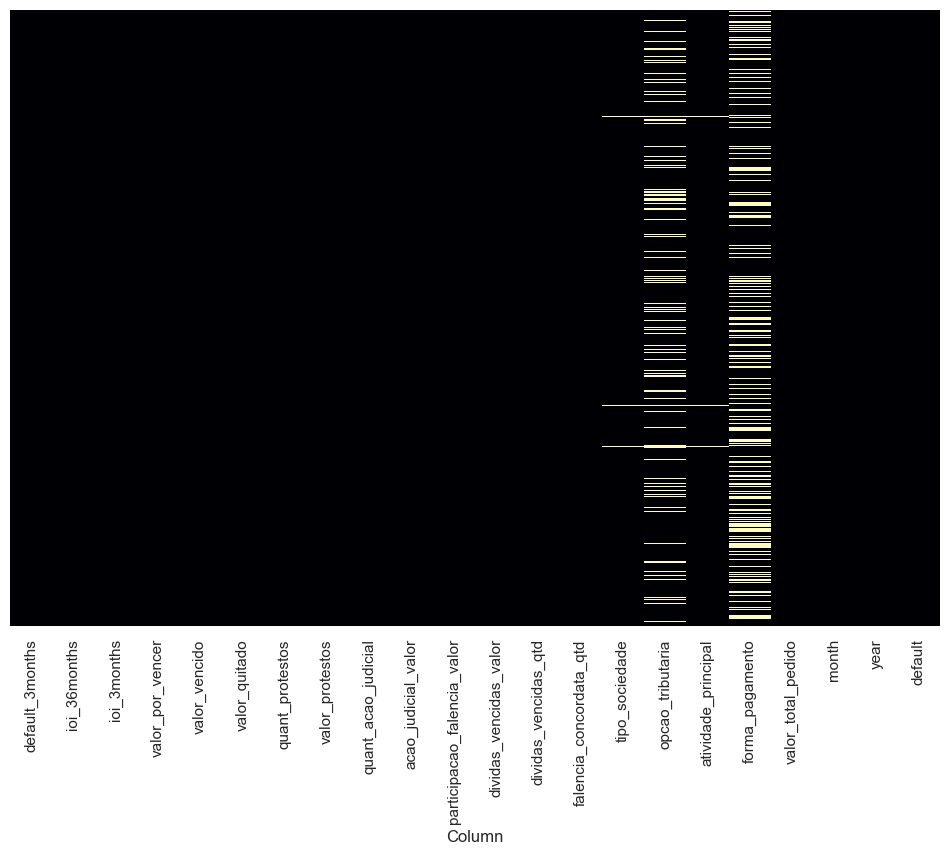

In [21]:
# Visualização de valores faltantes
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_raw.isnull(), yticklabels=False, cbar=False, cmap='magma', ax=ax)
plt.show()

 Existem três maneiras de tratar nossos dados faltantes:

 - Descartando completamente os dados faltantes

 - Utilizando o próprio comportamento da coluna para substituir os dados faltantes, utilizando de média ou mediana

 - Entendimento do negócio, utilizando algumas regras que podem ter passado despercebidas para substituir os dados faltantes a partir de um método mais específico para este dataset

- Para 'forma_pagamento', preenchi com a moda. Com 27.69% de faltantes, a moda reflete o método de pagamento mais comum entre os clientes, mantendo a representatividade da maioria sem descartar dados valiosos.
    - Dada a porcentagem alta de faltantes, outros tratamentos poderiam ser considerados, como imputação por um valor fixo ou modelo preditivo, mas isso poderia distorcer a distribuição original dos dados se não feito com cautela.
    - A moda, numa abordagem rápida, é uma escolha mais conservadora e visa distorcer o mínimo possível a distribuição original dos dados.

- Para 'opcao_tributaria', preenchi com a moda. Com 15.63% de faltantes, usar a moda preserva a tendência predominante de regime tributário, minimizando o impacto da imputação em uma variável relevante para o perfil financeiro dos clientes.

- Para 'atividade_principal' e 'tipo_sociedade', preenchi com a moda. Com apenas 0.50% e 0.52% de faltantes, a moda é uma escolha segura.


In [22]:
df_raw['forma_pagamento'] = df_raw['forma_pagamento'].fillna(df_raw['forma_pagamento'].mode()[0])
df_raw['tipo_sociedade'] = df_raw['tipo_sociedade'].fillna(df_raw['tipo_sociedade'].mode()[0])
df_raw['opcao_tributaria'] = df_raw['opcao_tributaria'].fillna(df_raw['opcao_tributaria'].mode()[0])
df_raw['atividade_principal'] = df_raw['atividade_principal'].fillna(df_raw['atividade_principal'].mode()[0])
missing_values, missing_columns_names = get_broadview_miss_val(df_raw)
missing_values

|| Broadview of missing values with percentages


,Absolute Missing (%),Column Missing (%),Column Remaining (%),Column Total,Column Missing
Column,,,,,
default_3months,0.00%,0.00%,100.00%,117273,0
ioi_36months,0.00%,0.00%,100.00%,117273,0
ioi_3months,0.00%,0.00%,100.00%,117273,0
valor_por_vencer,0.00%,0.00%,100.00%,117273,0
valor_vencido,0.00%,0.00%,100.00%,117273,0
valor_quitado,0.00%,0.00%,100.00%,117273,0
quant_protestos,0.00%,0.00%,100.00%,117273,0
valor_protestos,0.00%,0.00%,100.00%,117273,0
quant_acao_judicial,0.00%,0.00%,100.00%,117273,0


In [23]:
get_dataset_types(df_raw)

|| Identify data types of DataFrame columns


,Data_Type
Column,
default_3months,int64
ioi_36months,float64
ioi_3months,float64
valor_por_vencer,float64
valor_vencido,float64
valor_quitado,float64
quant_protestos,int64
valor_protestos,float64
quant_acao_judicial,int64


 ### Feature Extraction

In [24]:
# Criar variáveis derivadas para as hipóteses
df_raw['proporcao_divida'] = df_raw['valor_vencido'] / (df_raw['valor_quitado'] + 1)
df_raw['var_ioi'] = df_raw[['ioi_3months', 'ioi_36months']].std(axis=1)
df_raw['taxa_cresc_quitado'] = df_raw['valor_quitado'] / (df_raw['ioi_3months'] + 1)

In [25]:
df_raw[['proporcao_divida', 'var_ioi', 'taxa_cresc_quitado']].sample(15)

Column,proporcao_divida,var_ioi,taxa_cresc_quitado
38975,0.00%,52.19%,35620612.69%
25095,0.00%,0.00%,5335.52%
87489,0.00%,9864.27%,115007.78%
83245,0.00%,1103.87%,1418332.47%
72476,0.00%,3323.40%,209728.19%
19617,0.23%,81.21%,2716069.33%
6805,0.00%,268.70%,313952.29%
29989,0.00%,1579.21%,9236499.15%
53544,0.00%,2404.16%,512357.82%
79175,0.00%,1264.47%,1531440.56%


- Proporcao_divida mede a gravidade da dívida vencida em relação ao quitado, indicando risco financeiro
- Var_ioi captura a instabilidade nos intervalos de pedidos com base nos dados disponíveis, sugerindo inconsistência operacional por parte do cliente
- Taxa_cresc_quitado estima a dinâmica de pagamento ajustada por intervalo, refletindo saúde financeira recente

In [26]:
df_raw.columns.name = None

In [27]:
df_raw.columns

Index(['default_3months', 'ioi_36months', 'ioi_3months', 'valor_por_vencer',
       'valor_vencido', 'valor_quitado', 'quant_protestos', 'valor_protestos',
       'quant_acao_judicial', 'acao_judicial_valor',
       'participacao_falencia_valor', 'dividas_vencidas_valor',
       'dividas_vencidas_qtd', 'falencia_concordata_qtd', 'tipo_sociedade',
       'opcao_tributaria', 'atividade_principal', 'forma_pagamento',
       'valor_total_pedido', 'month', 'year', 'default', 'proporcao_divida',
       'var_ioi', 'taxa_cresc_quitado'],
      dtype='object')

In [28]:
df_raw.head()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,opcao_tributaria,atividade_principal,forma_pagamento,valor_total_pedido,month,year,default,proporcao_divida,var_ioi,taxa_cresc_quitado
0,0,5800.00%,1823.61%,0.00%,0.00%,24210070.00%,0,0.00%,0,0.00%,...,simples nacional,papelaria,30/60/90,3466567.49%,6,2019,0,0.00%,2811.73%,1258575.26%
1,1,1605.26%,750.00%,22413285.00%,0.00%,496084621.00%,0,0.00%,0,0.00%,...,simples nacional,com de equipamentos de informatica,30/60/90,713448.94%,10,2018,0,0.00%,604.76%,58362896.59%
2,0,1325.00%,390.48%,51304383.00%,0.00%,15863193.00%,1,180000.00%,0,0.00%,...,simples nacional,servicos de vigilancia e guarda,30/60/90,7265362.11%,4,2018,0,0.00%,660.81%,3234243.23%
3,0,13692.50%,1014.42%,2327364.00%,0.00%,66964416.00%,0,0.00%,0,0.00%,...,simples nacional,com de equipamentos de informatica,30/60/90,1457680.58%,4,2017,1,0.00%,8964.75%,6008892.62%
4,0,14033.33%,1765.17%,0.00%,0.00%,201056.00%,0,0.00%,0,0.00%,...,simples nacional,com de compon eletron e pecas para eletrod,30/60/90,265550.57%,10,2017,0,0.00%,8674.90%,10779.51%


 ## Data Analysis

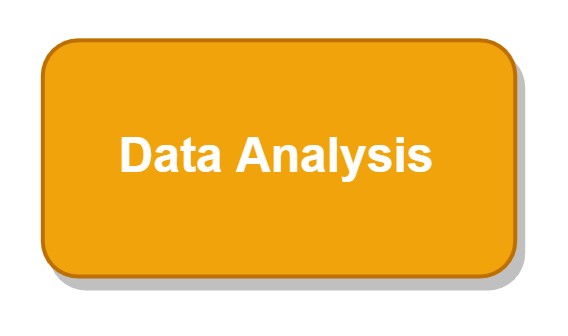

In [29]:
Image(filename='./Assets/Images/Data Analysis.png', width=200, height=100)

 ### Data Analysis Checkpoint

In [30]:
df2 = df_raw.copy()

df2.to_json('./Data/Refined/df2.json', orient = 'records', lines = True)

In [31]:
df2 = pd.read_json('./Data/Refined/df2.json', lines = True)

print("Checkpoint successful")

Checkpoint successful


In [32]:
df2.head()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,opcao_tributaria,atividade_principal,forma_pagamento,valor_total_pedido,month,year,default,proporcao_divida,var_ioi,taxa_cresc_quitado
0,0,5800.00%,1823.61%,0.00%,0.00%,24210070.00%,0,0.00%,0,0.00%,...,simples nacional,papelaria,30/60/90,3466567.49%,6,2019,0,0.00%,2811.73%,1258575.26%
1,1,1605.26%,750.00%,22413285.00%,0.00%,496084621.00%,0,0.00%,0,0.00%,...,simples nacional,com de equipamentos de informatica,30/60/90,713448.94%,10,2018,0,0.00%,604.76%,58362896.59%
2,0,1325.00%,390.48%,51304383.00%,0.00%,15863193.00%,1,180000.00%,0,0.00%,...,simples nacional,servicos de vigilancia e guarda,30/60/90,7265362.11%,4,2018,0,0.00%,660.81%,3234243.23%
3,0,13692.50%,1014.42%,2327364.00%,0.00%,66964416.00%,0,0.00%,0,0.00%,...,simples nacional,com de equipamentos de informatica,30/60/90,1457680.58%,4,2017,1,0.00%,8964.75%,6008892.62%
4,0,14033.33%,1765.17%,0.00%,0.00%,201056.00%,0,0.00%,0,0.00%,...,simples nacional,com de compon eletron e pecas para eletrod,30/60/90,265550.57%,10,2017,0,0.00%,8674.90%,10779.51%


 ### Descriptive Data Analysis

In [33]:
num_attributes = df2.select_dtypes(include=['int64', 'float64'])
cat_attributes = df2.select_dtypes(exclude=['int32','int64','float64', 'datetime64[ns]'])

In [34]:
num_attributes.head()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,dividas_vencidas_valor,dividas_vencidas_qtd,falencia_concordata_qtd,valor_total_pedido,month,year,default,proporcao_divida,var_ioi,taxa_cresc_quitado
0,0,5800.00%,1823.61%,0.00%,0.00%,24210070.00%,0,0.00%,0,0.00%,...,0.00%,0,0,3466567.49%,6,2019,0,0.00%,2811.73%,1258575.26%
1,1,1605.26%,750.00%,22413285.00%,0.00%,496084621.00%,0,0.00%,0,0.00%,...,0.00%,0,0,713448.94%,10,2018,0,0.00%,604.76%,58362896.59%
2,0,1325.00%,390.48%,51304383.00%,0.00%,15863193.00%,1,180000.00%,0,0.00%,...,0.00%,0,0,7265362.11%,4,2018,0,0.00%,660.81%,3234243.23%
3,0,13692.50%,1014.42%,2327364.00%,0.00%,66964416.00%,0,0.00%,0,0.00%,...,0.00%,0,0,1457680.58%,4,2017,1,0.00%,8964.75%,6008892.62%
4,0,14033.33%,1765.17%,0.00%,0.00%,201056.00%,0,0.00%,0,0.00%,...,0.00%,0,0,265550.57%,10,2017,0,0.00%,8674.90%,10779.51%


In [35]:
cat_attributes.head()

,tipo_sociedade,opcao_tributaria,atividade_principal,forma_pagamento
0,empresario (individual),simples nacional,papelaria,30/60/90
1,sociedade empresaria limitada,simples nacional,com de equipamentos de informatica,30/60/90
2,sociedade empresaria limitada,simples nacional,servicos de vigilancia e guarda,30/60/90
3,empresario (individual),simples nacional,com de equipamentos de informatica,30/60/90
4,sociedade empresaria limitada,simples nacional,com de compon eletron e pecas para eletrod,30/60/90


 #### Numerical Attributes

 Vamos analisar os atributos numéricos:

In [36]:
get_num_statistics_metrics(num_attributes)

|| Calculate descriptive statistics for numerical columns


,Min,Max,Range,Mean,Median,Standart Deviation,Skew,Kurtosis
Attributes,,,,,,,,
default_3months,0.00%,2600.00%,2600.00%,14.87%,0.00%,85.38%,1376.01%,27306.18%
ioi_36months,100.00%,95100.00%,95000.00%,5558.29%,3800.00%,6098.90%,389.39%,2585.31%
ioi_3months,100.00%,9000.00%,8900.00%,1710.63%,1600.00%,1099.36%,229.91%,830.05%
valor_por_vencer,0.00%,7219758636.00%,7219758636.00%,6421383.77%,445174.00%,52525238.62%,6220.93%,641543.27%
valor_vencido,0.00%,1315050000.00%,1315050000.00%,245404.26%,0.00%,8093278.01%,11159.78%,1555030.77%
valor_quitado,0.00%,46032032280.00%,46032032280.00%,108555733.62%,8134878.00%,744479367.24%,2076.80%,75117.65%
quant_protestos,0.00%,232400.00%,232400.00%,24.05%,0.00%,1070.78%,18202.56%,3822787.67%
valor_protestos,0.00%,1630545700.00%,1630545700.00%,205101.71%,0.00%,8831720.29%,11025.91%,1517020.57%
quant_acao_judicial,0.00%,8000.00%,8000.00%,1.89%,0.00%,53.40%,10425.00%,1286289.10%


 #### Categorical Attributes

 Vamos analisar os atributos categóricos:

In [37]:
get_unique_cat_values(cat_attributes)

|| Count unique values in categorical columns


,Unique Values Count,Unique Values
Attributes,,
tipo_sociedade,16,"[empresario (individual), sociedade empresaria..."
opcao_tributaria,4,"[simples nacional, lucro real, lucro presumido..."
atividade_principal,203,"[papelaria, com de equipamentos de informatica..."
forma_pagamento,104,"[30/60/90, 28 dias, 30/45, 60/90/120, 30/60/90..."


 ### Hypotheses



 Para chegarmos na Análise Exploratória de Dados e sabermos por qual caminho vamos nos guiar, vamos fazer uma lista de hipóteses a partir de três perguntas para analisar na próxima parte do projeto:



 - Qual o fenômeno modelado?

 - Quais são os agentes que atuam sobre o fenômeno de interesse?

 - Quais são os atributos dos agentes?

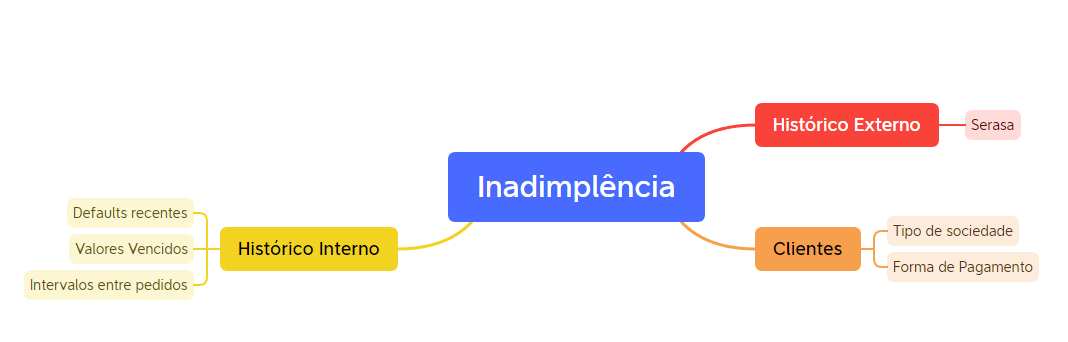

In [38]:
Image(filename='./Assets/Images/Hypotheses Mindmap.png', width=900, height=500)

 #### Hypotheses Questions

 - Qual o fenômeno modelado?

     - Previsão de inadimplência (default).

 - Quais são os agentes que atuam sobre o fenômeno de interesse?

     - Clientes B2B (empresas compradoras).

     - Histórico interno (X-Health).

     - Dados externos (Serasa).

     - Tempo entre pagamentos/pedidos

 - Quais são os atributos dos agentes?

 - Atributos:

     - Clientes

         - Tipo de sociedade

         - forma de pagamento

     - Histórico interno

         - Defaults recentes

         - valores vencidos

         - intervalos de pedidos

     - Serasa

         - Protestos

 #### Selected Hypotheses for the Analysis

1. Clientes com alta proporção de dívida vencida sobre o total quitado têm maior risco.
2. Clientes com maior variabilidade nos intervalos entre pedidos têm maior risco de default.
3. Clientes com uma taxa de crescimento negativa no valor quitado têm maior probabilidade de default.

 ##### Hypotheses Reasoning

As hipóteses foram escolhidas com base na relevância para o problema de inadimplência dos clientes da X-Health, no potencial preditivo sugerido pelas análises anteriores, e na viabilidade de validação com os dados disponíveis:

1. Clientes com alta proporção de dívida vencida sobre o total quitado têm maior risco.

- ```proporcao_divida = valor_vencido / (valor_quitado + 1)```
- Variável: Essa variável calcula a proporção (ou razão) entre o valor que o cliente deixou de pagar (valor_vencido) e o valor que ele já pagou (valor_quitado).

- Intenção: Queremos medir o quão "grave" é a dívida restante em relação ao histórico de pagamento do cliente.
    - Por exemplo: Se um cliente tem valor_vencido = 1000 e valor_quitado = 10000, a proporção é baixa (~0.1), sugerindo que ele geralmente paga bem e a dívida atual é pequena.
    - Se valor_vencido = 5000 e valor_quitado = 1000, a proporção é alta (~5), indicando que ele deve muito mais do que já pagou, o que é um sinal de risco.

- No contexto da X-Health: A hipótese é que clientes com uma proporção alta têm maior chance de dar calote (default), pois estão acumulando dívidas que superam sua capacidade de pagamento histórico.

- Em resumo: Mostra o "peso" da dívida não paga em relação ao que já foi pago, ajudando a identificar clientes em risco financeiro.

2. Clientes com maior variabilidade nos intervalos entre pedidos têm maior risco de default.

- ```var_ioi = df_raw[['ioi_3months', 'ioi_36months']].std(axis=1)```
- Variável: Essa variável calcula o desvio padrão entre os valores de ioi_3months e ioi_36months, que são intervalos médios entre pedidos nos últimos 3 e 36 meses, respectivamente.

- Intenção: O desvio padrão mede o quanto esses intervalos variam entre si.
    - Por exemplo: Se ioi_3months = 10 dias e ioi_36months = 12 dias, a variação é baixa (var_ioi pequeno), indicando que o cliente faz pedidos em intervalos consistentes.
    - Se ioi_3months = 5 dias e ioi_36months = 30 dias, a variação é alta (var_ioi grande), mostrando que os intervalos mudam muito.

- No contexto da X-Health: A hipótese é que clientes com alta variabilidade nos intervalos de pedidos (inconsistência) podem ter operações ou finanças instáveis, aumentando o risco de default. Um cliente que às vezes compra rápido num mês e às vezes demora muito para a próxima compra pode estar com problemas de fluxo de caixa.

- Em resumo: Tenta capturar uma "desordem" nos padrões de compra do cliente, sugerindo que instabilidade pode levar a calote.

3. Clientes com uma taxa de crescimento negativa no valor quitado (quanto mais tem dívida, mais compram com a X-Health) têm maior probabilidade de default.

- ```taxa_cresc_quitado = valor_quitado / (ioi_3months + 1)```
- Variável: Essa variável divide o valor total quitado (valor_quitado) pelo intervalo médio de pedidos nos últimos 3 meses (ioi_3months). É uma tentativa de aproximação para a "velocidade" ou "tendência" de pagamentos recentes.

- Intenção: Queremos estimar como o valor pago se comporta em relação à frequência mais recente de pedidos.
    - Por exemplo: Se valor_quitado = 10000 e ioi_3months = 10 dias, a ```taxa de crescimento de valor quitado``` é alta (~1000 por dia), sugerindo que o cliente paga bem e rápido.
    - Se valor_quitado = 1000 e ioi_3months = 50 dias, a taxa é baixa (~20 por dia), indicando que ele paga pouco em relação ao tempo entre pedidos, ou seja, demora para pagar.
    
- No contexto da X-Health: A hipótese é que clientes com uma taxa baixa (ou "crescimento negativo" no sentido de pagar pouco em pouco tempo) têm maior risco de default, pois mostram sinais de dificuldade financeira recente.

- Em resumo: Indica se o cliente está conseguindo pagar bem em relação ao ritmo recente de compras, refletindo sua "saúde" financeira atual.

 ### Exploratory Data Analysis

 Vamos listar primeiro quais os objetivos que queremos alcançar com a análise exploratória de dados.

 #### Objectives

 - Ganhar experiência de negócio

 - Validar hipóteses de negócio

 - Perceber quais variáveis são importantes para o modelo

 - Gerar Insigths sobre o negócio

 ##### Insights

 Os insights de dados referem-se à compreensão profunda que um indivíduo ou empresa obtém ao analisar seus dados sobre um problema específico de negócio.



 Essa compreensão profunda ajuda empresas a tomarem melhores decisões do que aquelas que se baseiam somente no instinto.

 Insights podem ser gerados de duas formas:

 - Surpresa

     - Uma conclusão nova surge através dos dados

 - Quebra de crenças

     - Quando uma crença empírica sobre o negócio é refutada, e provada que na verdade era o inverso ou que era completamente inválida e sem base sólida

 ##### Processes

 Quais são os processos que vamos utilizar para analisar os dados?

 - Análise Univariada

 - Análise Bivariada

 - Análise Multivariada

 Qual o objetivo de cada processo?

 - Análise Univariada

     - Como é essa variável?

     - Mínimos, máximos, distribuição, range

 - Análise Bivariada

     - Como essa variável impacta na variável alvo?

     - Correlação, validação de hipóteses

 - Análise Multivariada

     - Como as variáveis se relacionam?

     - Correlação, validação de hipóteses



 #### Univariate Analysis

 Vamos analisar as variáveis de forma univariada, ou seja, vamos analisar apenas uma variável por vez, sem relação com outras.

 ##### Target Variable

 São muitos dados, mas qual o nosso **foco**?

 - Nosso objeto de estudo principal é o produto pago ou não pago, ou seja, o default.

 - Vamos analisar a distribuição do default em relação aos atributos numéricos.

In [39]:
get_num_statistics_metrics(num_attributes).iloc[[-4]]

|| Calculate descriptive statistics for numerical columns


,Min,Max,Range,Mean,Median,Standart Deviation,Skew,Kurtosis
Attributes,,,,,,,,
default,0.00%,100.00%,100.00%,16.67%,0.00%,37.27%,178.89%,120.02%


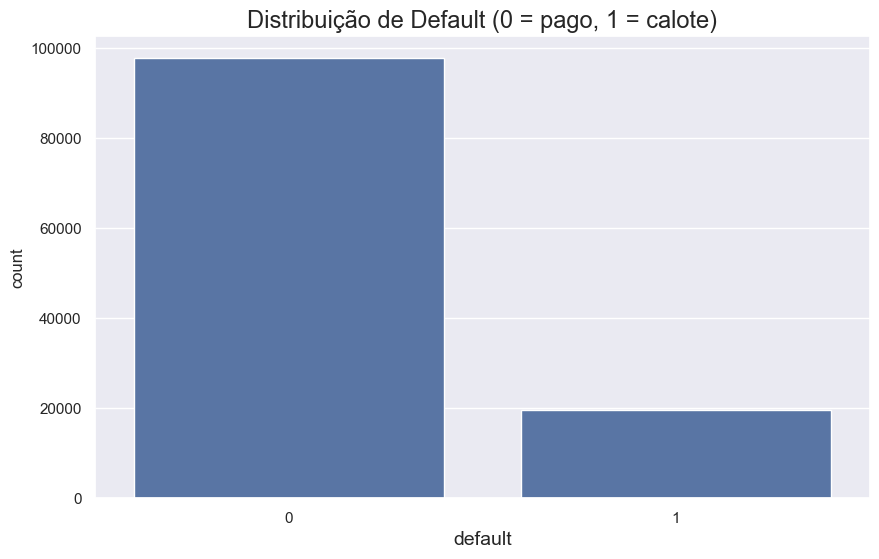

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(x='default', data=df2)
plt.title('Distribuição de Default (0 = pago, 1 = calote)', fontsize=17)
plt.xlabel('default', fontsize=14)
plt.show()

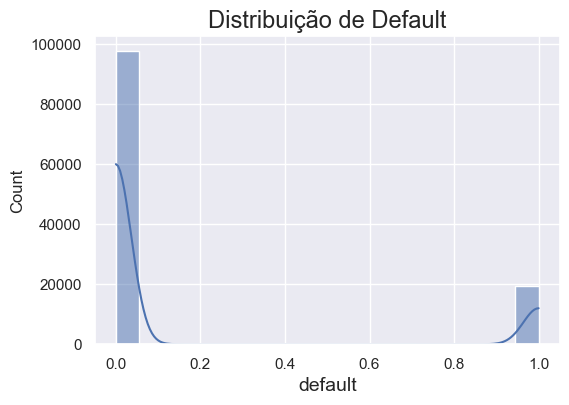

In [41]:
plt.figure(figsize=(6, 4))
fig = sns.histplot(df2['default'], kde=True)
fig.set_title('Distribuição de Default', fontsize=17)
fig.set_xlabel('default', fontsize=14)
plt.show()

É visivel que o pagamento em dia (Não default - 0) é muito mais comum do que o não pagamento (default -1).
Como a maioria dos clientes pagam em dia (default = 0), temos um problema de classificação binária desbalanceado.
Isso exige atenção especial à classe minoritária (inadimplência), mesmo usando modelos simples.

 ##### Numerical Variables

In [42]:
num_attributes = df2.select_dtypes(include=['int64','float64'])
num_attributes.head()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,dividas_vencidas_valor,dividas_vencidas_qtd,falencia_concordata_qtd,valor_total_pedido,month,year,default,proporcao_divida,var_ioi,taxa_cresc_quitado
0,0,5800.00%,1823.61%,0.00%,0.00%,24210070.00%,0,0.00%,0,0.00%,...,0.00%,0,0,3466567.49%,6,2019,0,0.00%,2811.73%,1258575.26%
1,1,1605.26%,750.00%,22413285.00%,0.00%,496084621.00%,0,0.00%,0,0.00%,...,0.00%,0,0,713448.94%,10,2018,0,0.00%,604.76%,58362896.59%
2,0,1325.00%,390.48%,51304383.00%,0.00%,15863193.00%,1,180000.00%,0,0.00%,...,0.00%,0,0,7265362.11%,4,2018,0,0.00%,660.81%,3234243.23%
3,0,13692.50%,1014.42%,2327364.00%,0.00%,66964416.00%,0,0.00%,0,0.00%,...,0.00%,0,0,1457680.58%,4,2017,1,0.00%,8964.75%,6008892.62%
4,0,14033.33%,1765.17%,0.00%,0.00%,201056.00%,0,0.00%,0,0.00%,...,0.00%,0,0,265550.57%,10,2017,0,0.00%,8674.90%,10779.51%


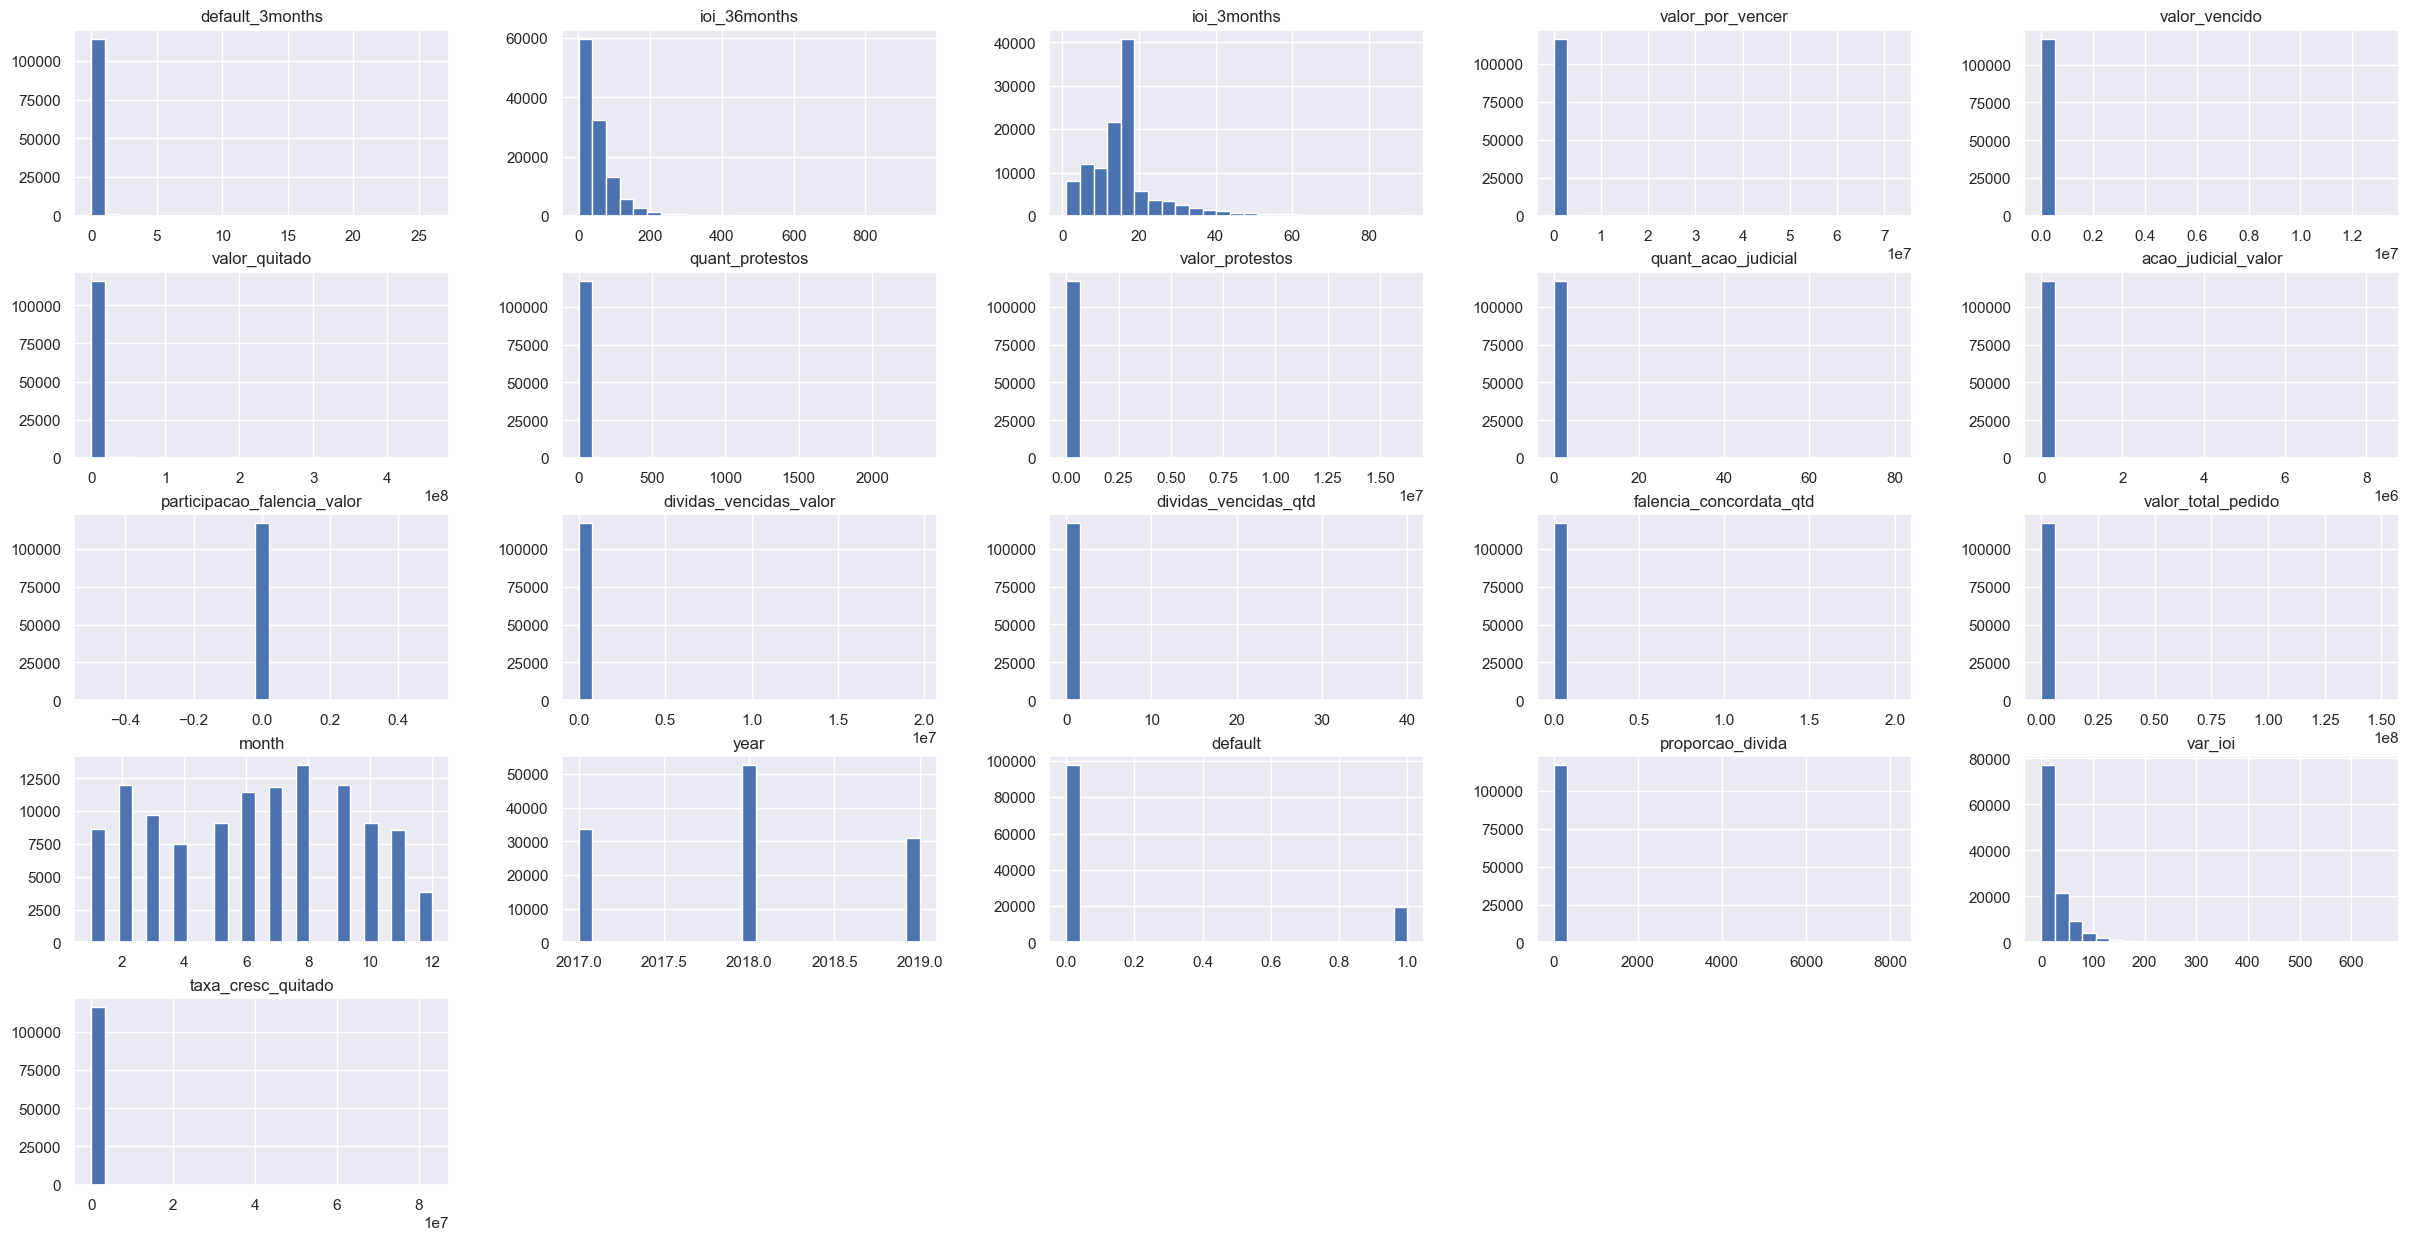

In [43]:
fig = plt.figure(figsize=(30, 15))
ax = fig.gca()
num_attributes.hist(ax=ax, bins=25)
plt.show()

 ##### Categorical Variables

 Vamos analisar as características das variáveis categóricas.

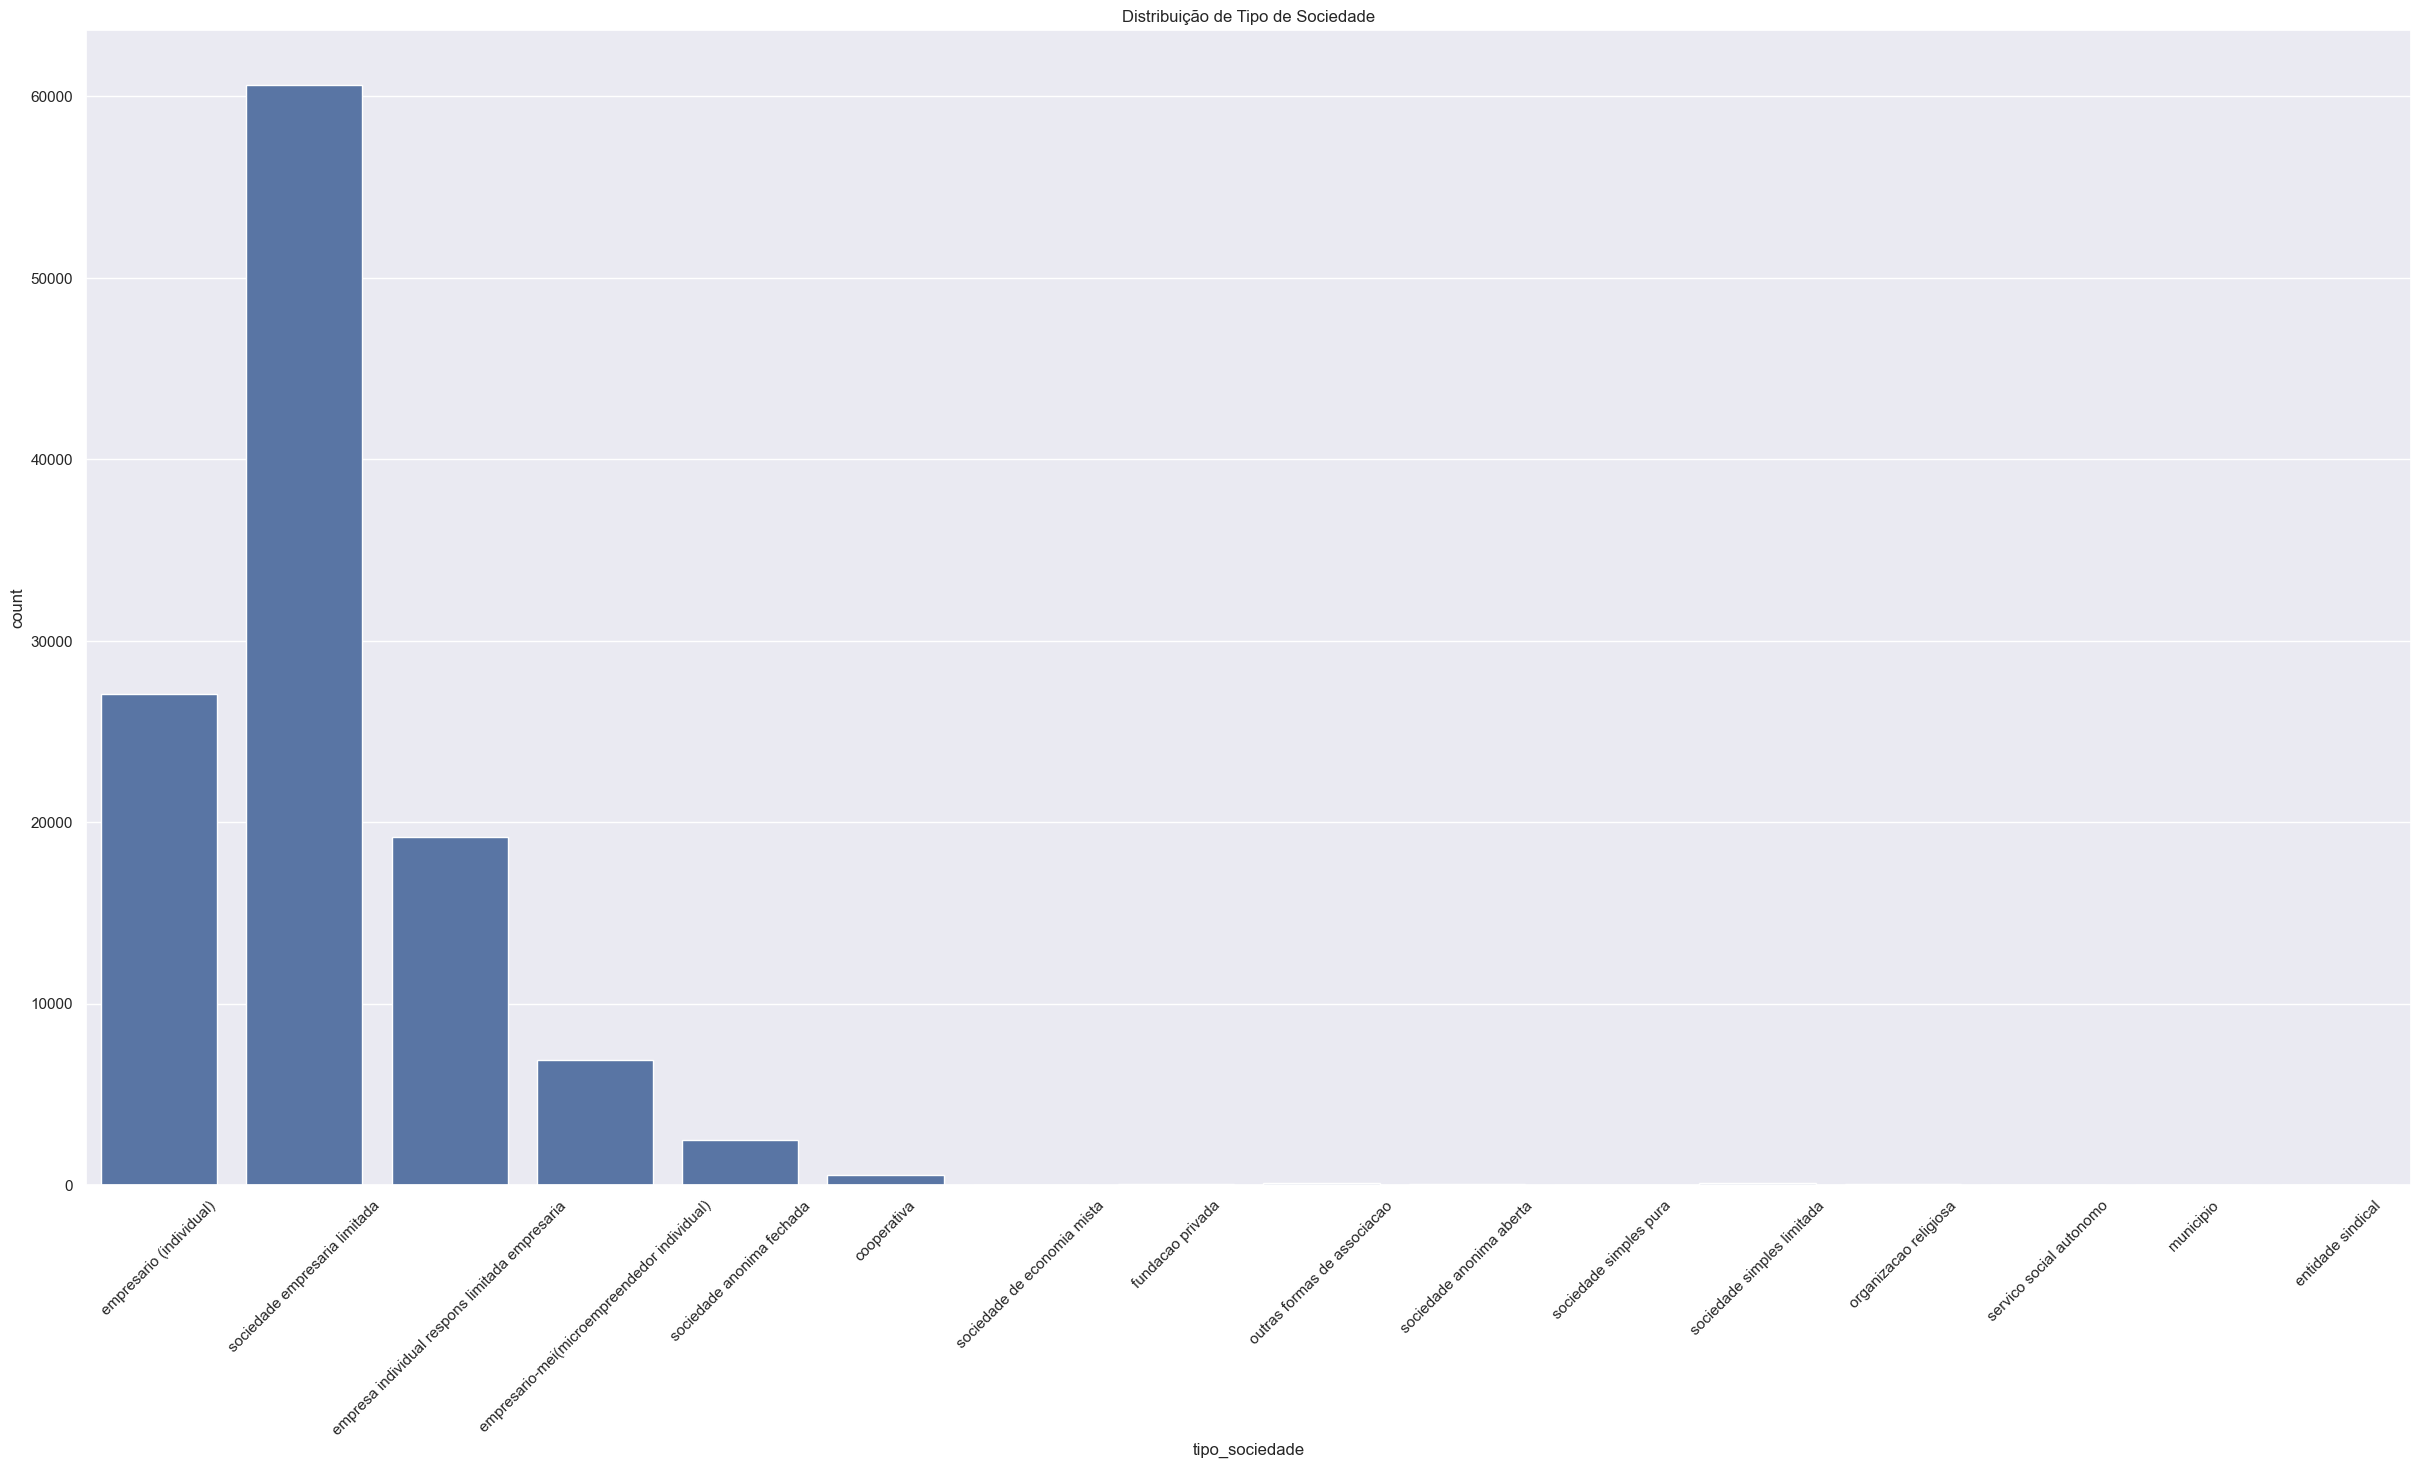

In [44]:
sns.countplot(x='tipo_sociedade', data=df2)
plt.title('Distribuição de Tipo de Sociedade')
plt.xticks(rotation=45)
plt.show()

 #### Bivariate Analysis

 ##### H1. Clientes com alta proporção de dívida vencida têm maior risco

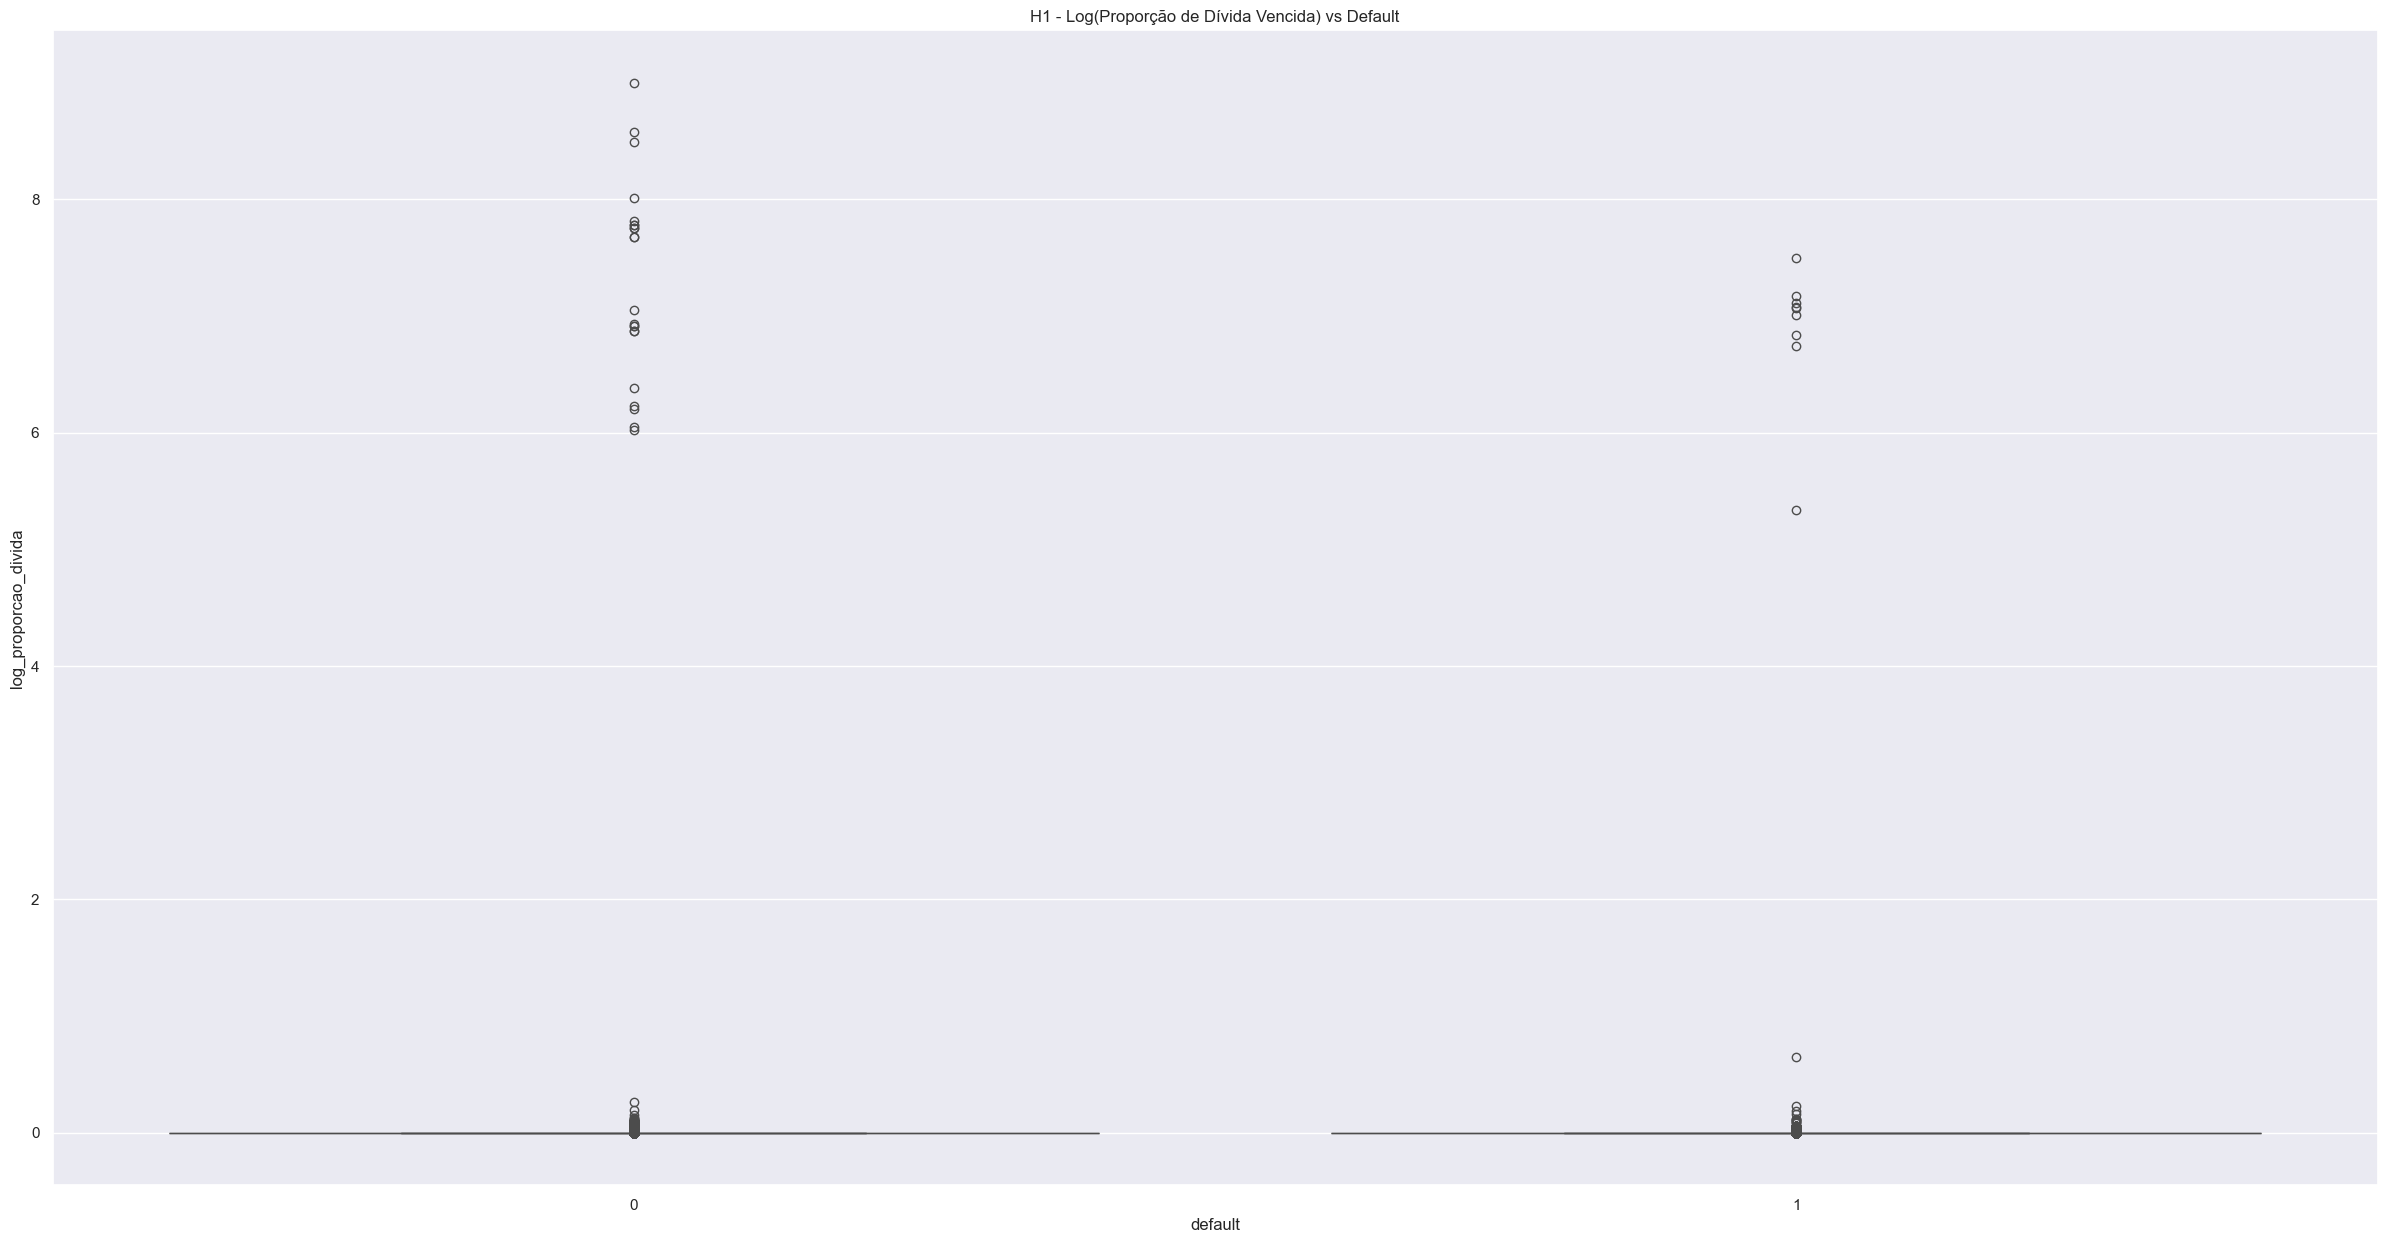

In [45]:
df2['log_proporcao_divida'] = np.log1p(df2['proporcao_divida'])

sns.boxplot(x='default', y='log_proporcao_divida', data=df2)
plt.title('H1 - Log(Proporção de Dívida Vencida) vs Default')
plt.show()


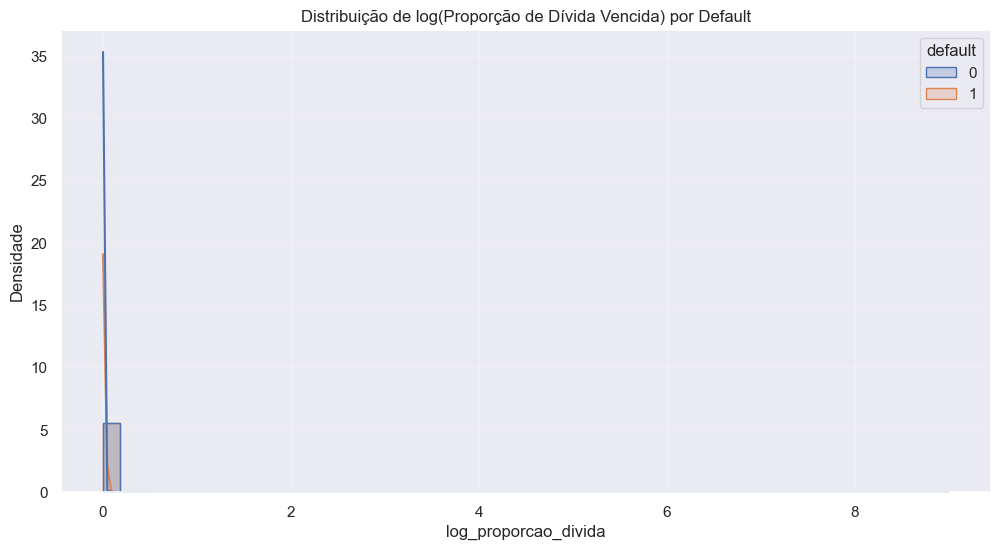

In [46]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df2, x='log_proporcao_divida', hue='default', bins=50, kde=True, element='step', stat='density', common_norm=False)
plt.title('Distribuição de log(Proporção de Dívida Vencida) por Default')
plt.xlabel('log_proporcao_divida')
plt.ylabel('Densidade')
plt.grid(True, alpha=0.2)
plt.show()

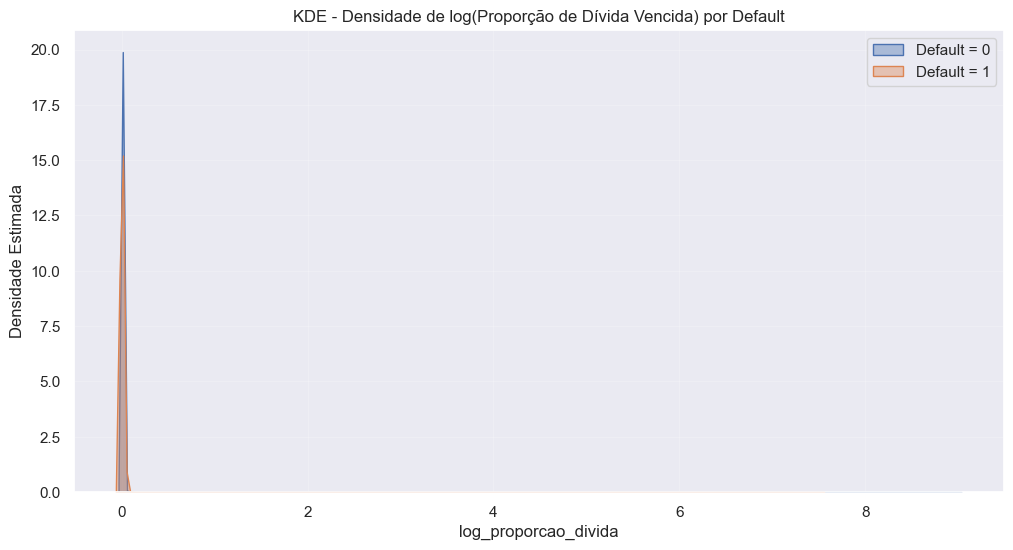

In [47]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df2[df2['default'] == 0], x='log_proporcao_divida', label='Default = 0', fill=True, alpha=0.4)
sns.kdeplot(data=df2[df2['default'] == 1], x='log_proporcao_divida', label='Default = 1', fill=True, alpha=0.4)
plt.title('KDE - Densidade de log(Proporção de Dívida Vencida) por Default')
plt.xlabel('log_proporcao_divida')
plt.ylabel('Densidade Estimada')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

- Baixa proporção de dívida vencida é comum tanto entre inadimplentes quanto entre adimplentes.

- Entretanto, valores altos de log_proporcao_divida são mais frequentes entre inadimplentes, mesmo sendo minoria.

- Logo, a log_proporcao_divida tem poder discriminativo, especialmente em casos extremos (valores altos).

- Um possível corte ou limiar alto dessa variável poderia ajudar a identificar um grupo de alto risco, embora a separação total entre classes não seja clara.

In [48]:
sts.mannwhitneyu(df2[df2['default'] == 0]['log_proporcao_divida'].dropna(), 
                df2[df2['default'] == 1]['log_proporcao_divida'].dropna())

MannwhitneyuResult(statistic=np.float64(831048289.5), pvalue=np.float64(0.0))

Como o p-valor é abaixo de 0.05, podemos rejeitar a hipótese nula (H0) com confiança, e aceitar a hipótese alternativa (H1):

A proporção de dívida vencida difere significativamente entre clientes inadimplentes e adimplentes.

Então, temos que H1 - Clientes com alta proporção de dívida vencida têm maior risco de inadimplência – tem grandes chances de ser verdadeira, pois o teste estatístico encontrou uma diferença significativa entre os grupos adimplentes e inadimplentes.

 ##### H2. Clientes com maior variabilidade nos intervalos entre pedidos têm maior risco de default

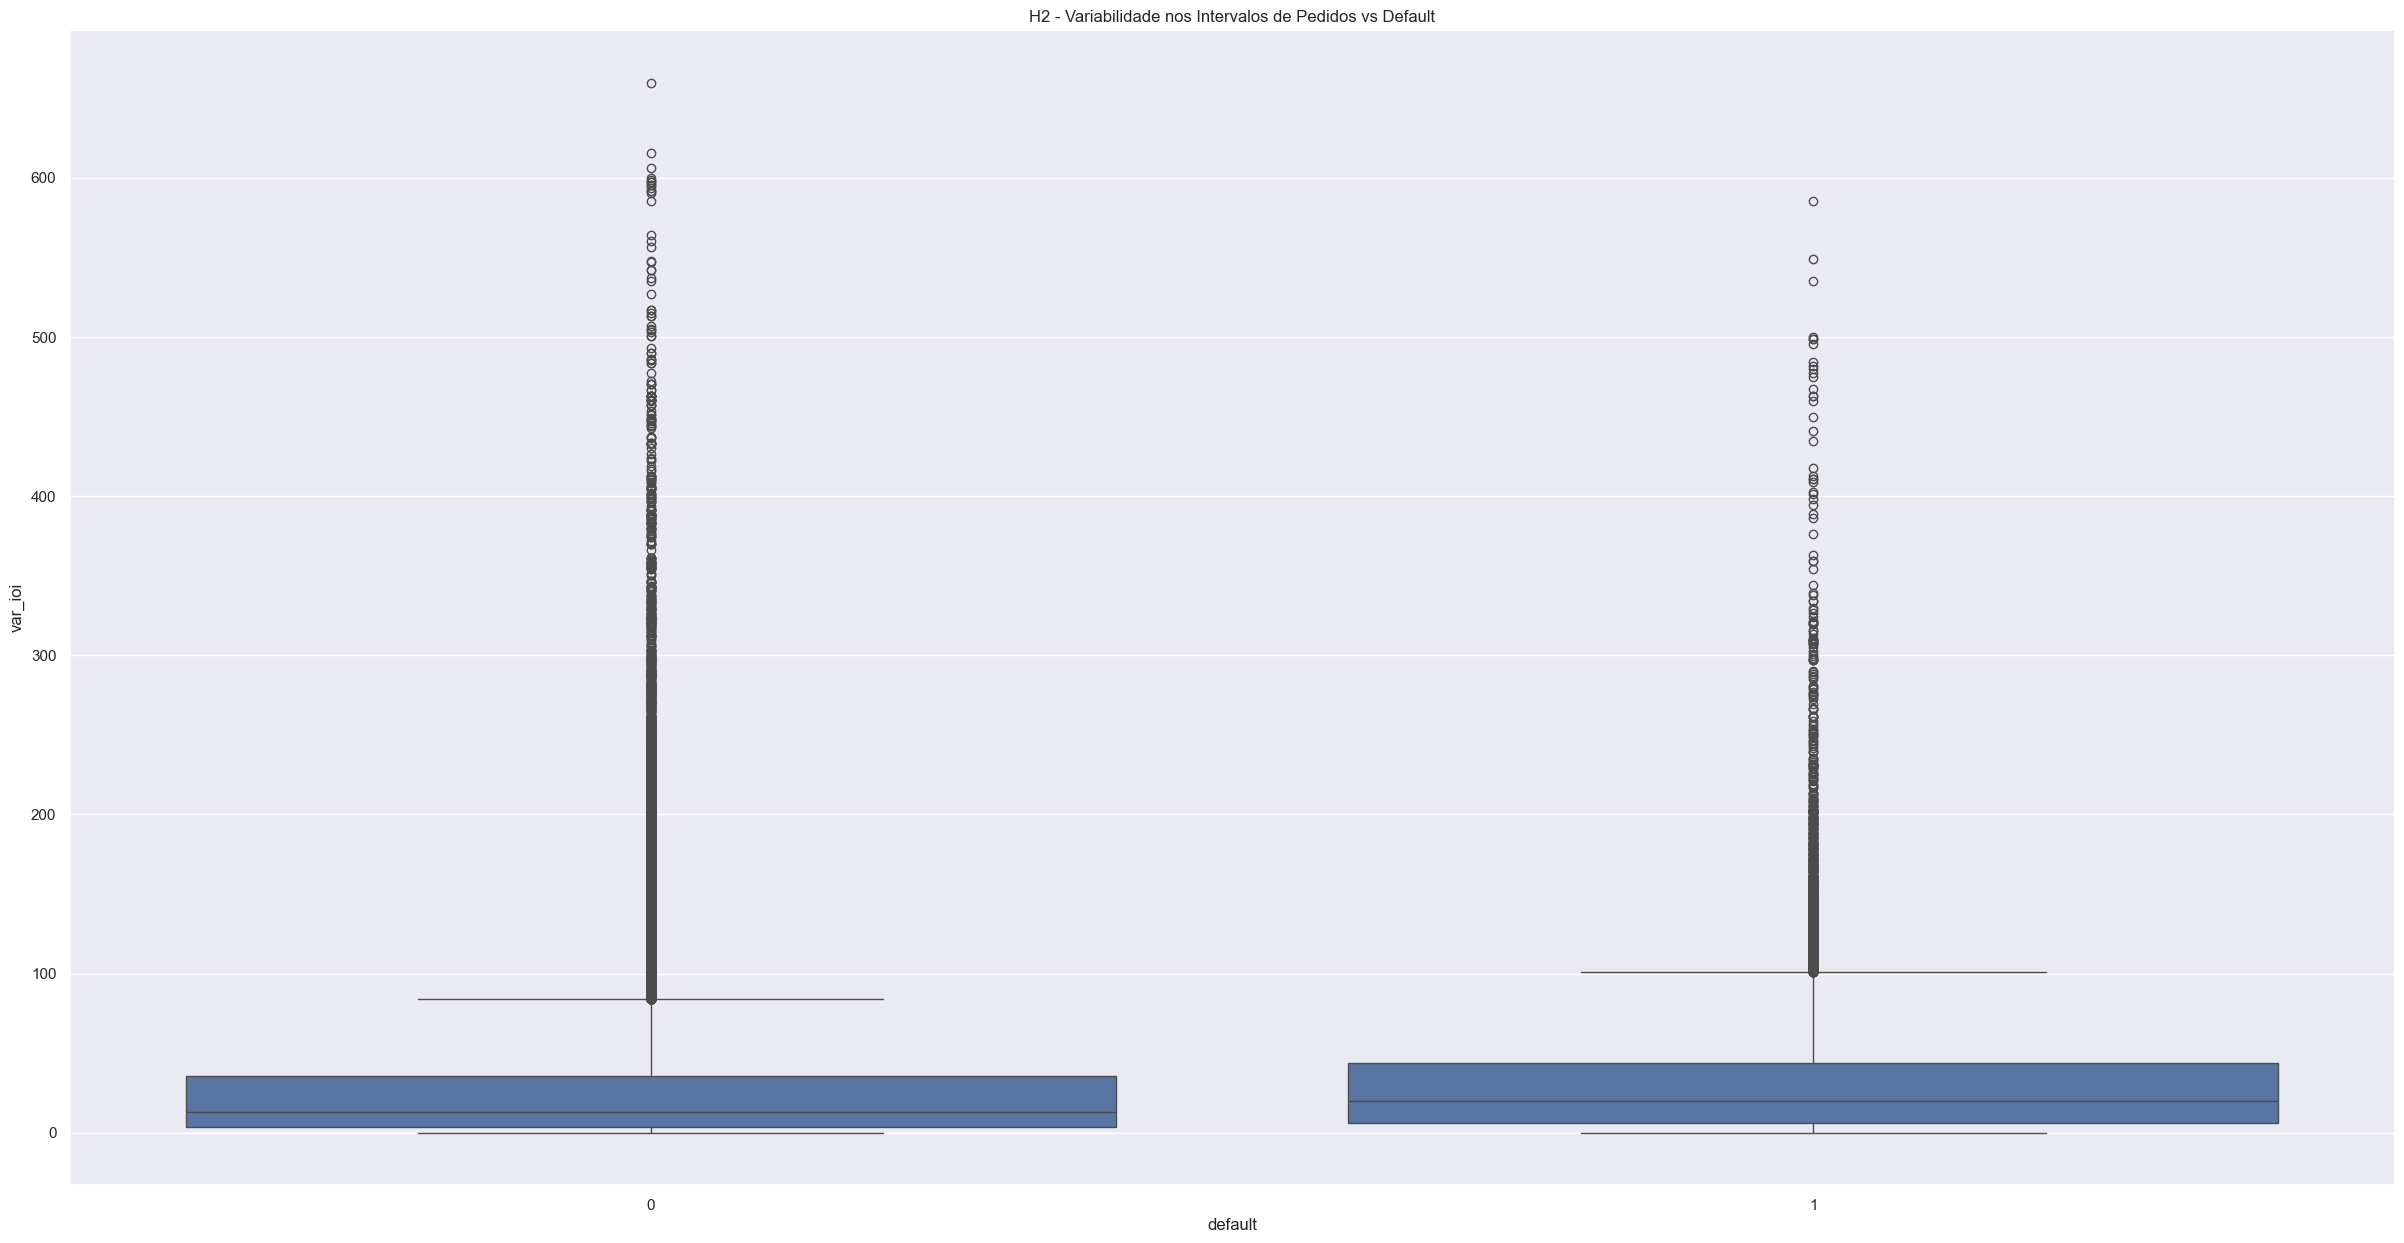

In [49]:
sns.boxplot(x='default', y='var_ioi', data=df2)
plt.title('H2 - Variabilidade nos Intervalos de Pedidos vs Default')
plt.show()

In [50]:
print(sts.mannwhitneyu(df2[df2['default'] == 0]['var_ioi'].dropna(), 
                        df2[df2['default'] == 1]['var_ioi'].dropna()))

MannwhitneyuResult(statistic=np.float64(825088186.5), pvalue=np.float64(7.931151789876909e-199))


O teste Mann-Whitney U tem p-valor muito baixo (7.93e-199), muito menor que 0.05, indica uma diferença estatisticamente significativa na variabilidade dos intervalos de pedidos (var_ioi) entre pagantes e inadimplentes, mas o boxplot revela que essa diferença é incerta na prática: as medianas são próximas de 0 para ambos os grupos, e a variabilidade maior está nos outliers, sugerindo que var_ioi pode não ser um preditor claro de default.

Implicação: A variável var_ioi pode ter algum valor preditivo (devido ao p-valor), mas não parece ser um indicador forte ou direto de inadimplência com base nesse gráfico.

 ##### H3. Clientes com uma taxa de crescimento negativa(ou mais baixa) no valor quitado têm maior probabilidade de default

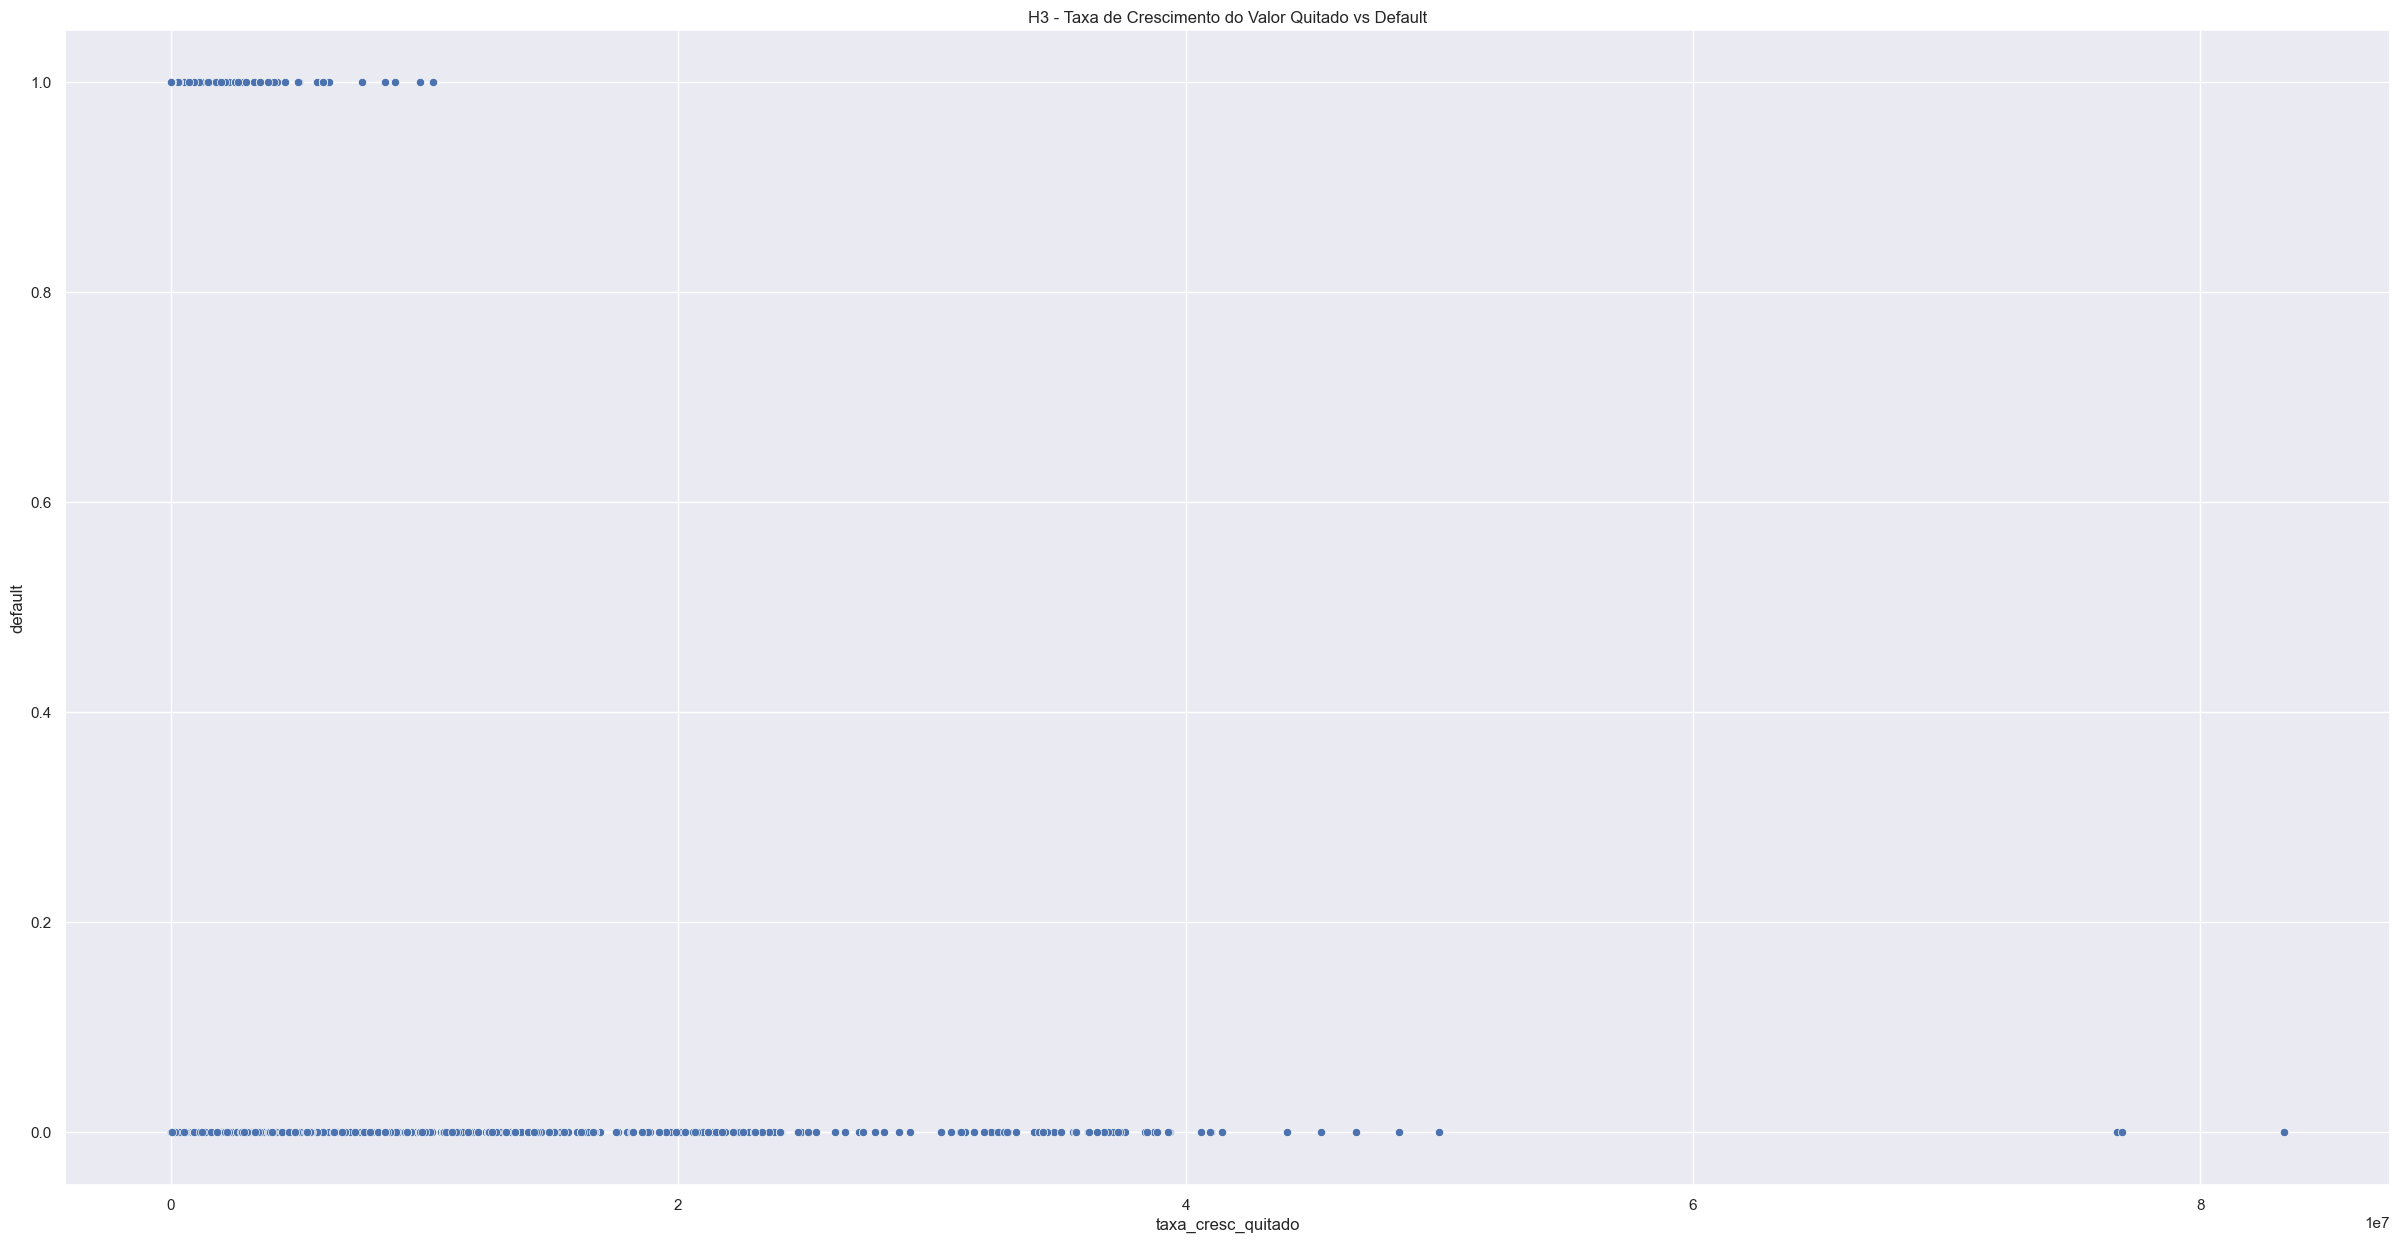

In [51]:
sns.scatterplot(x='taxa_cresc_quitado', y='default', data=df2)
plt.title('H3 - Taxa de Crescimento do Valor Quitado vs Default')
plt.show()

In [52]:
print(df2[['taxa_cresc_quitado', 'default']].corr(method='spearman'))

                    taxa_cresc_quitado  default
taxa_cresc_quitado             100.00%   -6.29%
default                         -6.29%  100.00%


O gráfico parece suportar a hipótese H3. Clientes em (1 - default) têm uma taxa de crescimento mais baixa no valor quitado, enquanto os inadimplentes (default = 1) têm taxas de crescimento mais altas. Isso sugere que a taxa de crescimento negativa pode estar associada a um maior risco de inadimplência.

Entretanto, a relação entre taxa_cresc_quitado e default é muito fraca (-0.0629)

Outros fatores podem estar influenciando o default, e a taxa_cresc_quitado sozinha não parece ser um indicador significativo.

 #### Hypotheses Validation

In [53]:
conclusions =  [['H1', 'Verdadeira', 'Média', 'Sim'],  
                ['H2', 'Falsa', 'Baixa', 'Não'],  
                ['H3', 'Falsa', 'Baixa', 'Não'],]
print(tabulate(conclusions, headers='firstrow'))


H1    Verdadeira    Média    Sim
----  ------------  -------  -----
H2    Falsa         Baixa    Não
H3    Falsa         Baixa    Não


In [54]:
Hypotheses = get_analysis_conclusions(conclusions, columns_included = False)
Hypotheses

,Conclusão,Relevância,Insigth
Hipóteses,,,
H1,Verdadeira,Média,Sim
H2,Falsa,Baixa,Não
H3,Falsa,Baixa,Não


 #### Multivariate Analysis

 ##### Numerical Attributes

In [55]:
num_attributes.head()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,dividas_vencidas_valor,dividas_vencidas_qtd,falencia_concordata_qtd,valor_total_pedido,month,year,default,proporcao_divida,var_ioi,taxa_cresc_quitado
0,0,5800.00%,1823.61%,0.00%,0.00%,24210070.00%,0,0.00%,0,0.00%,...,0.00%,0,0,3466567.49%,6,2019,0,0.00%,2811.73%,1258575.26%
1,1,1605.26%,750.00%,22413285.00%,0.00%,496084621.00%,0,0.00%,0,0.00%,...,0.00%,0,0,713448.94%,10,2018,0,0.00%,604.76%,58362896.59%
2,0,1325.00%,390.48%,51304383.00%,0.00%,15863193.00%,1,180000.00%,0,0.00%,...,0.00%,0,0,7265362.11%,4,2018,0,0.00%,660.81%,3234243.23%
3,0,13692.50%,1014.42%,2327364.00%,0.00%,66964416.00%,0,0.00%,0,0.00%,...,0.00%,0,0,1457680.58%,4,2017,1,0.00%,8964.75%,6008892.62%
4,0,14033.33%,1765.17%,0.00%,0.00%,201056.00%,0,0.00%,0,0.00%,...,0.00%,0,0,265550.57%,10,2017,0,0.00%,8674.90%,10779.51%


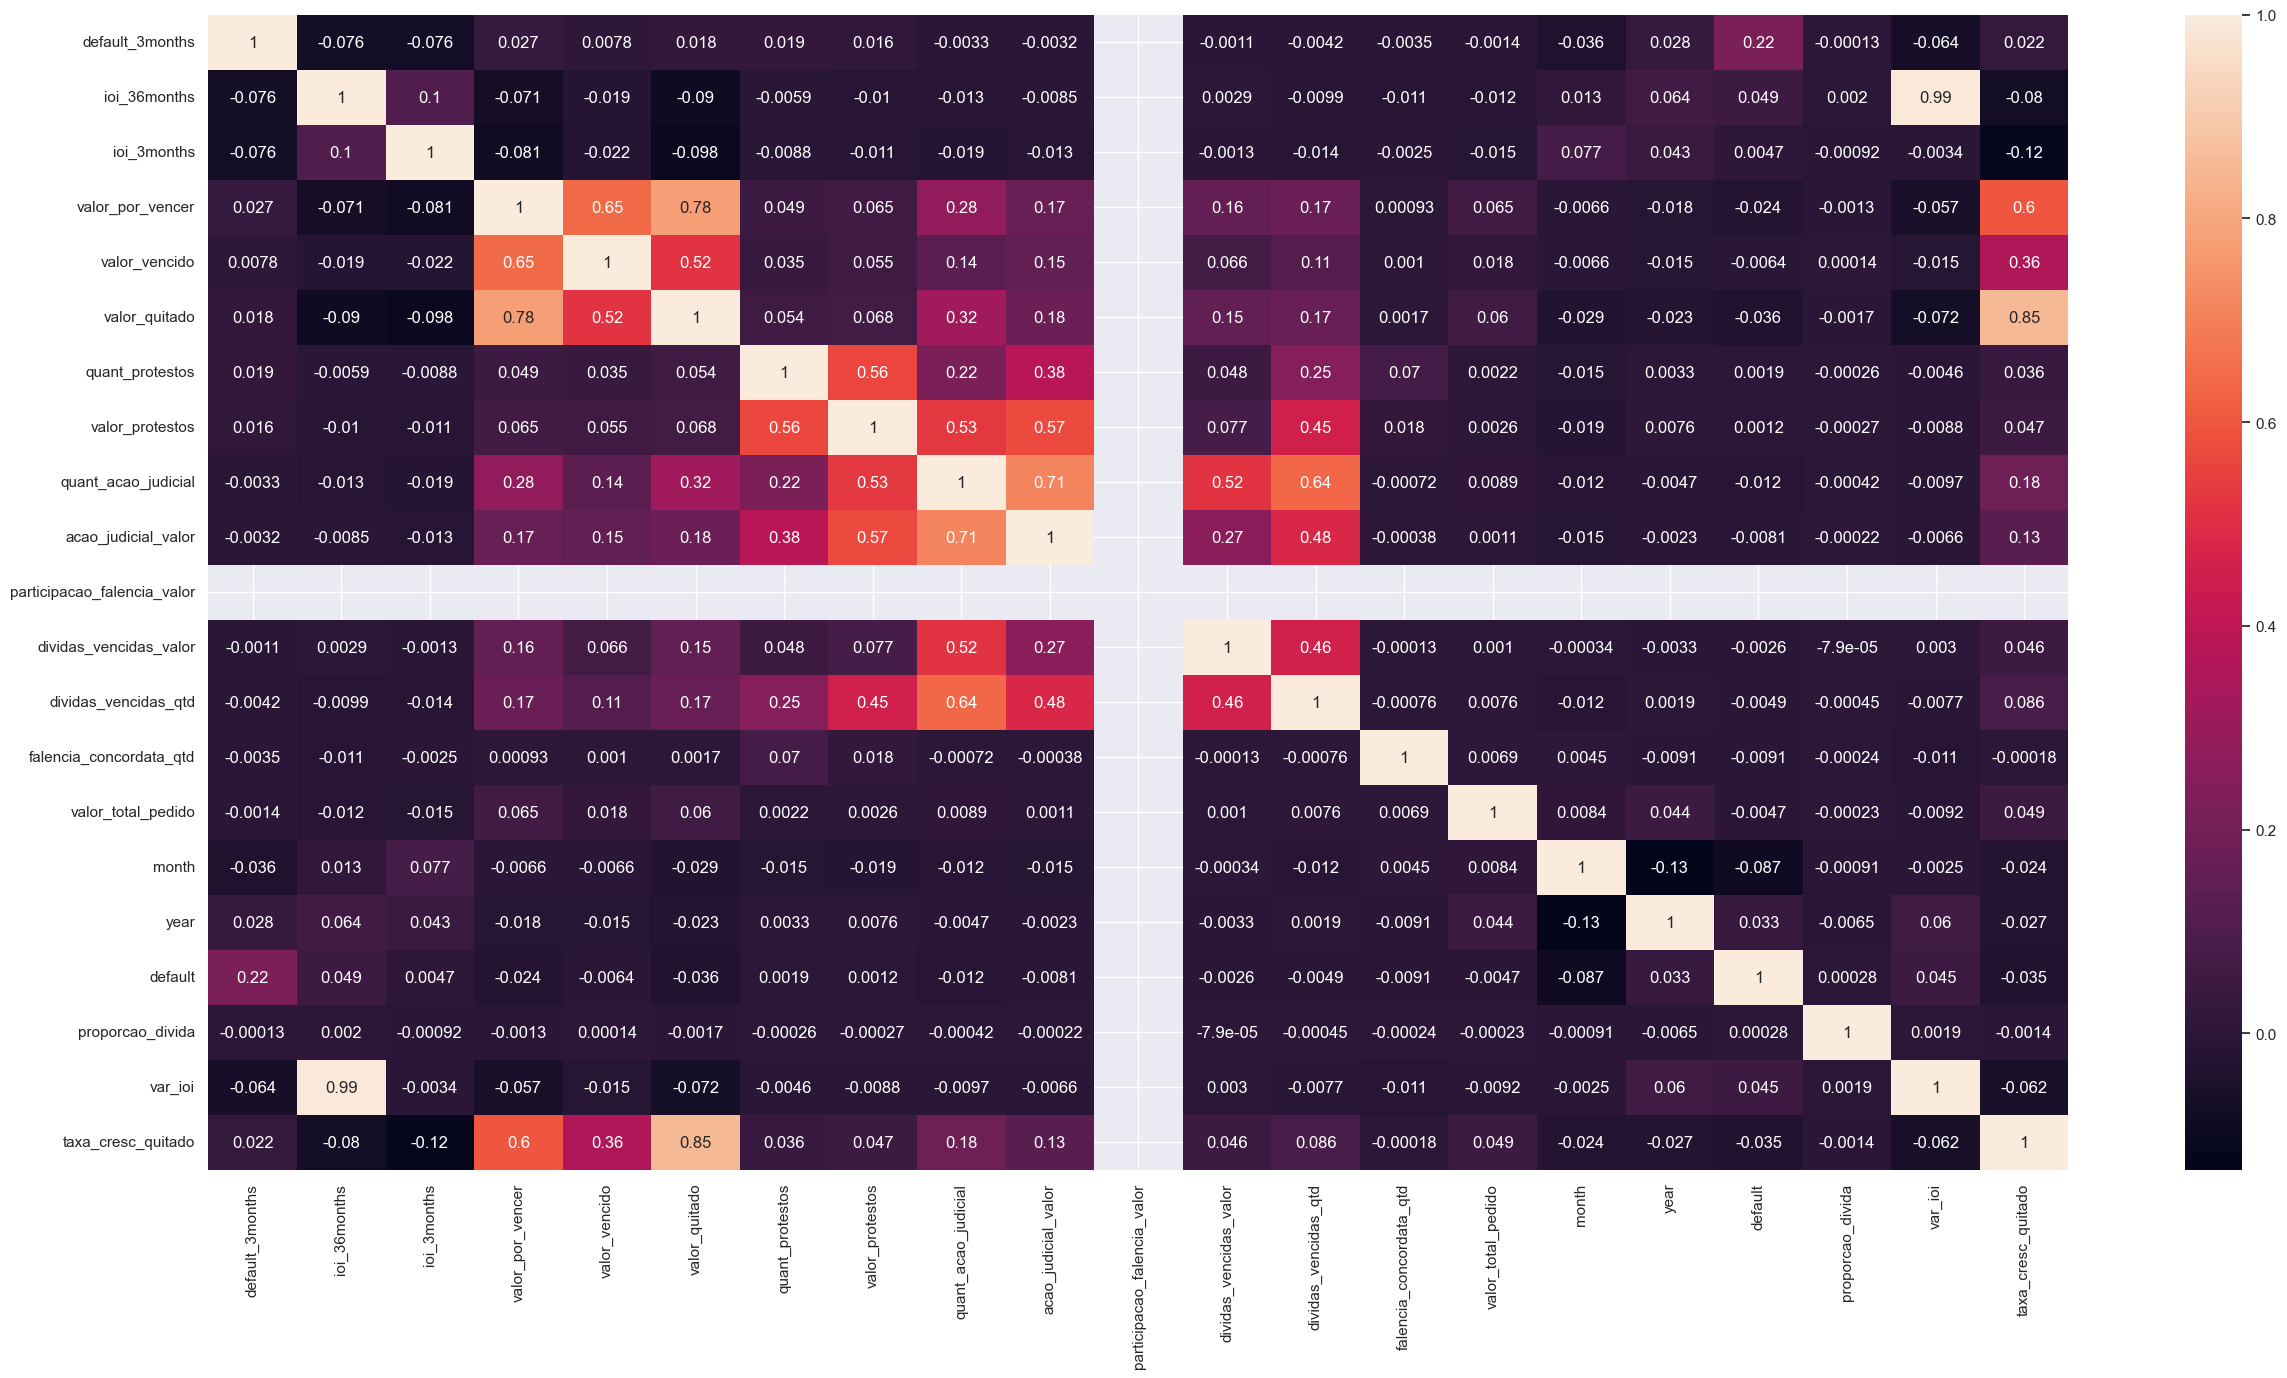

In [56]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)
plt.show()

- A variável "default_3months" apresenta a correlação mais forte com "default" (0.22), indicando que o histórico recente de inadimplência é o melhor preditor de futuros calotes.
- Existe uma correlação praticamente exata (0.99) entre "ioi_36months" e "var_ioi", sugerindo redundância entre elas.

Há fortes correlações positivas entre:
- "valor_por_vencer" e "valor_quitado" (0.78)
- "valor_por_vencer" e "taxa_cresc_quitado" (0.60)
- "quant_acao_judicial" e "acao_judicial_valor" (0.71)
- "dividas_vencidas_valor" e "dividas_vencidas_qtd" (0.46)


- As variáveis temporais "month" e "year" têm correlação fraca com "default" (-0.087 e 0.033)
- Variáveis relacionadas a protestos mostram correlação moderada entre si, como "quant_protestos" e "valor_protestos" (0.56)
- Variáveis que seriam intuitivamente importantes para prever default, como "valor_vencido", têm correlação fraca com a variável alvo (-0.0064).

Esta análise sugere que um modelo preditivo eficaz para o nosso problema deveria priorizar o histórico recente de inadimplência, enquanto evitando variáveis redundantes como "ioi_36months" e "var_ioi" juntas.